## Audio genre detection

The task of audio sample genre detection is usually solved using neural networks. I am trying to develop an alternative approach using classical ML algorithm (gradient boosting over decision trees to be precise) and manual feature extraction and selection. The dataset used is GTZAN consisting of 1000 30-second tracks of ten genres. The best known accuracy on this dataset (using NNs) is 0.95, I achieve score of 0.81.

The pipeline is as follows, I divide the dataset into train and eval sets in proportion 0.8/0.2. Then I design feature extraction and tune hyperparameters using cross-validation on train part of the dataset only. In the end of the notebook the eval dataset is used to compute the final score. The reason for that is following: I want to detect if the hyperparameters are indeed tuned to the real distribution of data rather then validation dataset. I use feature_importances reported by catboost model trained on the whole train part for feature selection and utilize optuna to tune hyperparameters. This imposes the risk that validation data in some sense leak into parameters chosen. Therefore only cross-validation on train part is used for tuning, while eval set is accessed only at the end.

In [1]:
# Install dependencies
!pip install -r requirements.txt

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)
!cp -rf {path} ./dataset

In [1]:
import pandas as pd
import numpy as np
from model import *
from dagxtractor import DAGXtractor, mapper, flat_mapper

There are some features provided with the dataset. We will train a model on those features and use the resulting score as baseline. But in the final model only the features extracted from the audio file itself are used

In [2]:
import pandas as pd
df = pd.read_csv("dataset/Data/features_30_sec.csv")
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [3]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['label'])  # Features: e.g., 'track' and 'statistics'
y = df['label']  # Target: 'label'

# Split the dataset while preserving class proportions
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y,
    test_size=0.2,  # 20% for testing
    stratify=y,     # Preserve class proportions
    random_state=42 # For reproducibility
)

In [4]:
# Drop corrupted sample
idx = X_train.index[X_train["filename"] == "jazz.00054.wav"]
X_train = X_train.drop(index=idx)
y_train = y_train.drop(index=idx)

Train baseline model

In [5]:
model, acc = train_and_evaluate_catboost(
    X_train.drop(columns=["filename", "length"]).to_numpy(),
    y_train.to_numpy(),
)

0:	learn: 0.2989045	total: 65.8ms	remaining: 32.8s
100:	learn: 0.8247261	total: 295ms	remaining: 1.16s
200:	learn: 0.9092332	total: 519ms	remaining: 772ms
300:	learn: 0.9561815	total: 741ms	remaining: 490ms
400:	learn: 0.9812207	total: 963ms	remaining: 238ms
499:	learn: 0.9953052	total: 1.24s	remaining: 0us
0:	learn: 0.3818466	total: 4.74ms	remaining: 2.36s
100:	learn: 0.8356808	total: 262ms	remaining: 1.03s
200:	learn: 0.9107981	total: 530ms	remaining: 789ms
300:	learn: 0.9655712	total: 797ms	remaining: 527ms
400:	learn: 0.9859155	total: 1.06s	remaining: 261ms
499:	learn: 0.9921753	total: 1.29s	remaining: 0us
0:	learn: 0.3302034	total: 4.39ms	remaining: 2.19s
100:	learn: 0.8325509	total: 239ms	remaining: 942ms
200:	learn: 0.9139280	total: 449ms	remaining: 667ms
300:	learn: 0.9546166	total: 664ms	remaining: 439ms
400:	learn: 0.9796557	total: 888ms	remaining: 219ms
499:	learn: 0.9890454	total: 1.09s	remaining: 0us
0:	learn: 0.3208138	total: 3.7ms	remaining: 1.84s
100:	learn: 0.8435055	t

In [5]:
import soundfile as sf
import librosa
import numpy as np
import resampy

I runned out of RAM using plain numpy to compute features and the calculations got messy, therefore I developed a minimal local map-reduce framework.
It has a very restricted set of features, but it supports dropping data on disk on the fly which is enough for the project.

In [6]:
sr = 22050
hop_length = 512
n_mfcc = 20
n_mels = 128
n_bins = 84
bins_per_octave = 12
fmin = librosa.note_to_hz("C1")
fmax = fmin * 2 ** 7
n_fft=2048
mel_proj = librosa.filters.mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax)
cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)

class Extractor(DAGXtractor):
    @mapper("audio")
    def load_audio(x) -> [np.ndarray]:
        file_path = f"dataset/Data/genres_original/{x[0].split('.')[0]}/{x[0]}"
        y, sr = sf.read(file_path)
        if len(y.shape) == 2:  # Convert stereo to mono
            y = np.mean(y, dim=0)
        if sr != 22050:
            y = resample(y, sr, 22050)
        return y[:660000].astype('float32') # Sizes of samples slightly differ
    @mapper("stats")
    def stats(x):
        return x[2:-1]
    @mapper("labels")
    def labels(x):
        return x[-1]
    # RMS of the audio, represents the volume of the track.
    @mapper("rms", batched=True)
    def rms(audio):
        return np.sqrt(np.mean(audio**2, axis=-1))
    # STFT spectrogram - the track is divided in short overlapping windows, they are processed with windowing functions 
    # and Fourier transform is computed for each frame. The result is spectrogram representing the energy for each timeframe and frequency bin.
    @mapper("complex_stft", batched=False, uniform=True)
    def complex_stft(audio):
        return librosa.stft(audio, hop_length=hop_length, n_fft=n_fft)
    # Compute the actual magnitude
    @mapper("stft", batched=True)
    def stft(complex_stft):
        return np.abs(complex_stft)
    # STFT has a bad resolution for low frequencies and to hight resolution for high frequencies. CQT is a way to compute energy for frequency bins corresponding to notes.
    @mapper("complex_cqt", batched=False, uniform=True)
    def complex_cqt(audio):
        return librosa.cqt(audio, sr=sr, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)
    @mapper("cqt", batched=True)
    def cqt(complex_cqt):
        return np.abs(complex_cqt)
    # MEL is another way to overcome too high resolution of STFT for high frequencies. We just multiply the STFT output with the linear filter, 
    # getting frequency bins corresponding to "the resolution in which we hear frequencies". Additionally we transform amplitudes to decibels, 
    # (it's basically a logarithm with some constants) which again better correspond to the way we hear volume.
    @mapper("mel", batched=False)
    def mel(stft):
        return librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft**2, optimize=True))
    # MFCC - take another Fourier transform of MEL, we may think of it as a way to project MEL spectrogram on some meaningful basis to reduce dimension.
    # Also it may be considered as a way to capture overtones of base frequency, but in that case cepstrum over unscaled MEL seems more useful.
    @mapper("mfcc", batched=True)
    def mfcc(audio):
        return librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)

In [7]:
E_train = Extractor(
    x=np.hstack([X_train.to_numpy(), y_train.to_numpy().reshape(-1, 1)]),
)
E_eval = Extractor(
    x=np.hstack([X_eval.to_numpy(), y_eval.to_numpy().reshape(-1, 1)])
)
E_train.full_extract()

Running extractor for features audio at 2025-02-17 17:59:41.038970
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 17:59:43.635475 total running time 0:00:02.596505
Running extractor for features complex_stft at 2025-02-17 17:59:43.635594
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 17:59:53.936710 total running time 0:00:10.301116
Running extractor for features stft at 2025-02-17 17:59:53.936844


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:00:53.920654 total running time 0:00:59.983810
Running extractor for features mel at 2025-02-17 18:00:53.922316
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:01:18.757779 total running time 0:00:24.835463
Running extractor for features labels at 2025-02-17 18:01:18.757988
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:01:18.801940 total running time 0:00:00.043952
Running extractor for features complex_cqt at 2025-02-17 18:01:18.802026
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:01:53.260493 total running time 0:00:34.458467
Running extractor for features cqt at 2025-02-17 18:01:53.260810


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:01:54.977810 total running time 0:00:01.717000
Running extractor for features rms at 2025-02-17 18:01:54.977842


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:01:55.591270 total running time 0:00:00.613428
Running extractor for features stats at 2025-02-17 18:01:55.591322
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:01:55.642137 total running time 0:00:00.050815
Running extractor for features mfcc at 2025-02-17 18:01:55.642250


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:02:18.141114 total running time 0:00:22.498864


In [8]:
# We will use only BPM that is the fastness of the track
def bpm_beat(audio):
    return librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length)
Extractor.register_mapper(['bpm', 'beat'], bpm_beat, uniform=False)
# Extractor.register_mapper('bpm', lambda audio: librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length)[0])

In [9]:
E_train.soft_extract()

Running extractor for features bpm, beat at 2025-02-17 18:14:02.975976


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:14:41.944396 total running time 0:00:38.968420


In [10]:
# Seporate percussive and harmonic parts of the spectrogram
def stft_hpss(complex_stft):
    stft_harmonic, stft_percussive = librosa.decompose.hpss(complex_stft)
    return np.abs(stft_harmonic), np.abs(stft_percussive)
Extractor.register_mapper(['stft_harmonic', 'stft_percussive'], stft_hpss)

In [11]:
E_train.soft_extract()

Running extractor for features stft_harmonic, stft_percussive at 2025-02-17 18:14:41.978625
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:29:07.240430 total running time 0:14:25.261805


In [12]:
# We do it in a single run, for the sake of optimization
def mel_hpss(stft_harmonic, stft_percussive):
    return (
        np.mean(stft_harmonic),
        np.var(stft_harmonic),
        np.mean(stft_percussive),
        np.var(stft_percussive),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_harmonic**2, optimize=True)),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_percussive**2, optimize=True)),
    )

Extractor.register_mapper(['stft_harmonic_mean', 'stft_harmonic_var', 'stft_percussive_mean', 'stft_percussive_var', 'mel_harmonic', 'mel_percussive'], mel_hpss)
E_train.soft_extract()

Running extractor for features stft_harmonic_mean, stft_harmonic_var, stft_percussive_mean, stft_percussive_var, mel_harmonic, mel_percussive at 2025-02-17 18:29:07.284652
Failed compiling function, will use plain python wrapper, exception: tuple index out of range


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:30:12.094200 total running time 0:01:04.809548


In [13]:
Extractor.register_mapper(['cqt_harmonic', 'cqt_percussive'], lambda cqt: librosa.decompose.hpss(cqt))


In [14]:
E_train.soft_extract()

Running extractor for features cqt_harmonic, cqt_percussive at 2025-02-17 18:30:12.120943
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:21.897944 total running time 0:01:09.777001


The simplest way to make a set of the features out of the spectrogram is to calculate a mean over the whole track. Lets firstly implement it

## Spectral features

In [ ]:
Extractor.register_mapper('cqt_mean', lambda cqt: cqt.mean())
Extractor.register_mapper('cqt_var', lambda cqt: cqt.var())
Extractor.register_mapper('cqt_freq_mean', lambda cqt: cqt.mean(axis=1))
Extractor.register_mapper('cqt_freq_var', lambda cqt: cqt.var(axis=1))
Extractor.register_mapper('cqt_harmonic_mean', lambda cqt_harmonic: cqt_harmonic.mean())
Extractor.register_mapper('cqt_harmonic_var', lambda cqt_harmonic: cqt_harmonic.var())
Extractor.register_mapper('cqt_harmonic_freq_mean', lambda cqt_harmonic: cqt_harmonic.mean(axis=1))
Extractor.register_mapper('cqt_harmonic_freq_var', lambda cqt_harmonic: cqt_harmonic.var(axis=1))
Extractor.register_mapper('cqt_percussive_mean', lambda cqt_percussive: cqt_percussive.mean())
Extractor.register_mapper('cqt_percussive_var', lambda cqt_percussive: cqt_percussive.var())
Extractor.register_mapper('cqt_percussive_freq_mean', lambda cqt_percussive: cqt_percussive.mean(axis=1))
Extractor.register_mapper('cqt_percussive_freq_var', lambda cqt_percussive: cqt_percussive.var(axis=1))

Extractor.register_mapper('stft_mean', lambda stft: stft.mean(axis=1))
Extractor.register_mapper('stft_var', lambda stft: stft.var(axis=1))
Extractor.register_mapper('mel_freq_mean', lambda mel: mel.mean(axis=1))
Extractor.register_mapper('mel_freq_var', lambda mel: mel.var(axis=1))
Extractor.register_mapper('mel_harmonic_freq_mean', lambda mel_harmonic: mel_harmonic.mean(axis=1))
Extractor.register_mapper('mel_harmonic_freq_var', lambda mel_harmonic: mel_harmonic.var(axis=1))
Extractor.register_mapper('mel_percussive_freq_mean', lambda mel_percussive: mel_percussive.mean(axis=1))
Extractor.register_mapper('mel_percussive_freq_var', lambda mel_percussive: mel_percussive.var(axis=1))

In [17]:
E_train.soft_extract()

Running extractor for features mel_percussive_freq_mean at 2025-02-17 18:31:23.376155
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:23.826018 total running time 0:00:00.449863
Running extractor for features mel_freq_mean at 2025-02-17 18:31:23.826052
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:27.396963 total running time 0:00:03.570911
Running extractor for features stft_var at 2025-02-17 18:31:27.397002
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:51.712279 total running time 0:00:24.315277
Running extractor for features cqt_freq_mean at 2025-02-17 18:31:51.712398
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:51.842568 total running time 0:00:00.130170
Running extractor for features mel_percussive_freq_var at 2025-02-17 18:31:51.842673
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:52.058180 total running time 0:00:00.215507
Running extractor for features cqt_percussive_var at 2025-02-17 18:31:52.058211
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:52.248641 total running time 0:00:00.190430
Running extractor for features cqt_percussive_freq_mean at 2025-02-17 18:31:52.248682
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:52.280882 total running time 0:00:00.032200
Running extractor for features mel_harmonic_freq_mean at 2025-02-17 18:31:52.280914
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:54.398541 total running time 0:00:02.117627
Running extractor for features cqt_var at 2025-02-17 18:31:54.398592
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:54.463859 total running time 0:00:00.065267
Running extractor for features cqt_percussive_freq_var at 2025-02-17 18:31:54.463897
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:54.538053 total running time 0:00:00.074156
Running extractor for features mel_freq_var at 2025-02-17 18:31:54.538089
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:54.739038 total running time 0:00:00.200949
Running extractor for features cqt_harmonic_freq_mean at 2025-02-17 18:31:54.739078
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:54.841135 total running time 0:00:00.102057
Running extractor for features cqt_harmonic_mean at 2025-02-17 18:31:54.841166
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:54.870828 total running time 0:00:00.029662
Running extractor for features mel_harmonic_freq_var at 2025-02-17 18:31:54.870860
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:55.004199 total running time 0:00:00.133339
Running extractor for features cqt_percussive_mean at 2025-02-17 18:31:55.004237
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:55.032478 total running time 0:00:00.028241
Running extractor for features cqt_harmonic_var at 2025-02-17 18:31:55.032507
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:55.104120 total running time 0:00:00.071613
Running extractor for features stft_mean at 2025-02-17 18:31:55.104152
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:56.095845 total running time 0:00:00.991693
Running extractor for features cqt_harmonic_freq_var at 2025-02-17 18:31:56.095897
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:56.168745 total running time 0:00:00.072848
Running extractor for features cqt_freq_var at 2025-02-17 18:31:56.168776
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:56.263854 total running time 0:00:00.095078
Running extractor for features cqt_mean at 2025-02-17 18:31:56.263896
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:31:56.293773 total running time 0:00:00.029877


In [18]:
features = ['cqt_freq_mean', 'cqt_freq_var', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2895149	total: 354ms	remaining: 2m 56s
100:	learn: 0.7965571	total: 2.54s	remaining: 10s
200:	learn: 0.8748044	total: 4.49s	remaining: 6.68s
300:	learn: 0.9374022	total: 6.34s	remaining: 4.19s
400:	learn: 0.9640063	total: 8.12s	remaining: 2s
499:	learn: 0.9874804	total: 9.94s	remaining: 0us
0:	learn: 0.3004695	total: 26.5ms	remaining: 13.2s
100:	learn: 0.7918623	total: 1.86s	remaining: 7.33s
200:	learn: 0.8935837	total: 3.67s	remaining: 5.45s
300:	learn: 0.9264476	total: 5.47s	remaining: 3.62s
400:	learn: 0.9640063	total: 7.26s	remaining: 1.79s
499:	learn: 0.9859155	total: 9.08s	remaining: 0us
0:	learn: 0.3004695	total: 29.1ms	remaining: 14.5s
100:	learn: 0.7809077	total: 1.83s	remaining: 7.23s
200:	learn: 0.8873239	total: 3.65s	remaining: 5.43s
300:	learn: 0.9311424	total: 5.43s	remaining: 3.59s
400:	learn: 0.9640063	total: 7.19s	remaining: 1.77s
499:	learn: 0.9765258	total: 9.07s	remaining: 0us
0:	learn: 0.2456964	total: 27.8ms	remaining: 13.8s
100:	learn: 0.7762128	total

In [19]:
# Add MFCC statictics
Extractor.register_mapper('mfcc_quef_mean', lambda mfcc: mfcc.mean(axis=1))
Extractor.register_mapper('mfcc_quef_var', lambda mfcc: mfcc.var(axis=1))


# Spectral centroid is just a weithed mean of frequency bins. Represents the center of frequency mass
Extractor.register_mapper('spectral_centroid',
                             lambda audio: librosa.feature.spectral_centroid(y=audio, sr=sr))

Extractor.register_mapper('spectral_centroid_mean', lambda spectral_centroid: spectral_centroid.mean())
Extractor.register_mapper('spectral_centroid_var', lambda spectral_centroid: spectral_centroid.var())

# Chroma is basically the frequencies mapped to bins corresponding to nodes and octaves are collapsed. 
# It is indirect way to represent tonality
chroma_map = librosa.filters.cq_to_chroma(cqt_frequencies.shape[0], bins_per_octave=bins_per_octave, n_chroma=bins_per_octave, fmin=fmin)
Extractor.register_mapper('cqt_chroma',
                             lambda cqt: librosa.feature.chroma_cqt(C=cqt, sr=sr, hop_length=hop_length, fmin=fmin))
Extractor.register_mapper('cqt_chroma_freq_mean', lambda cqt_chroma: cqt_chroma.mean(axis=1))
Extractor.register_mapper('cqt_chroma_freq_var', lambda cqt_chroma: cqt_chroma.var(axis=1))
Extractor.register_mapper('cqt_chroma_mean', lambda cqt_chroma: cqt_chroma.mean())
Extractor.register_mapper('cqt_chroma_var', lambda cqt_chroma: cqt_chroma.var())

# Compute it also for harmonic part of the track only
Extractor.register_mapper('cqt_harmonic_chroma',
                             lambda cqt_harmonic: librosa.feature.chroma_cqt(C=cqt_harmonic, sr=sr, hop_length=hop_length, fmin=fmin))
Extractor.register_mapper('cqt_harmonic_chroma_freq_mean', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.mean(axis=1))
Extractor.register_mapper('cqt_harmonic_chroma_freq_var', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.var(axis=1))
Extractor.register_mapper('cqt_harmonic_chroma_mean', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.mean())
Extractor.register_mapper('cqt_harmonic_chroma_var', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.var())

# Rollof is the frequency below which the specified quantile of energy mass lies
roll_percent = 0.85
Extractor.register_mapper('rolloff',
                             lambda stft: librosa.feature.spectral.spectral_rolloff(S=stft, sr=sr, roll_percent=roll_percent))

Extractor.register_mapper('rolloff_mean', lambda rolloff: rolloff.mean())
Extractor.register_mapper('rolloff_var', lambda rolloff: rolloff.var())

# Weithed (with energy) variance of frequency bins
Extractor.register_mapper('bandwidth',
                             lambda stft: librosa.feature.spectral.spectral_bandwidth(S=stft, sr=sr, n_fft=n_fft))

Extractor.register_mapper('bandwidth_mean', lambda bandwidth: bandwidth.mean())
Extractor.register_mapper('bandwidth_var', lambda bandwidth: bandwidth.var())

# The number of times the signal crosses zero value, indirect way to measure frequency
Extractor.register_mapper('zero_crossing_rate',
                             lambda audio: librosa.feature.zero_crossing_rate(y=audio))

Extractor.register_mapper('zero_crossing_rate_mean', lambda zero_crossing_rate: zero_crossing_rate.mean())
Extractor.register_mapper('zero_crossing_rate_var', lambda zero_crossing_rate: zero_crossing_rate.var())

# CQT but with energy levels scaled in "the way that me hear them" depending on the frequency
Extractor.register_mapper('percept', lambda cqt: librosa.perceptual_weighting(cqt**2, cqt_frequencies, ref=np.max))
Extractor.register_mapper('percept_freq_mean', lambda percept: percept.mean(axis=1))
Extractor.register_mapper('percept_freq_var', lambda percept: percept.var(axis=1))
Extractor.register_mapper('percept_mean', lambda percept: percept.mean())
Extractor.register_mapper('percept_var', lambda percept: percept.var())

# Same as CQT chroma but computed over STFT, I experiment with both
Extractor.register_mapper('stft_chroma', lambda stft: librosa.feature.chroma_stft(S=stft**2, sr=sr))
Extractor.register_mapper('stft_chroma_freq_mean', lambda stft_chroma: np.mean(stft_chroma, axis=1))
Extractor.register_mapper('stft_chroma_freq_var', lambda stft_chroma: np.var(stft_chroma, axis=1))
Extractor.register_mapper('stft_chroma_mean', lambda stft_chroma: np.mean(stft_chroma))
Extractor.register_mapper('stft_chroma_var', lambda stft_chroma: np.var(stft_chroma))

In [20]:
E_train.soft_extract()

Running extractor for features percept at 2025-02-17 18:32:56.223271
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:32:59.245894 total running time 0:00:03.022623
Running extractor for features percept_mean at 2025-02-17 18:32:59.245946
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:32:59.304120 total running time 0:00:00.058174
Running extractor for features zero_crossing_rate at 2025-02-17 18:32:59.304154
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:13.648341 total running time 0:00:14.344187
Running extractor for features zero_crossing_rate_var at 2025-02-17 18:33:13.648437
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:13.662431 total running time 0:00:00.013994
Running extractor for features cqt_chroma at 2025-02-17 18:33:13.662476
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:15.274377 total running time 0:00:01.611901
Running extractor for features cqt_chroma_freq_mean at 2025-02-17 18:33:15.274552
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:15.325124 total running time 0:00:00.050572
Running extractor for features stft_chroma at 2025-02-17 18:33:15.325198
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:39.193830 total running time 0:00:23.868632
Running extractor for features stft_chroma_freq_mean at 2025-02-17 18:33:39.193925
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:39.261844 total running time 0:00:00.067919
Running extractor for features spectral_centroid at 2025-02-17 18:33:39.261924
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:51.856857 total running time 0:00:12.594933
Running extractor for features cqt_harmonic_chroma at 2025-02-17 18:33:51.856900
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:54.342571 total running time 0:00:02.485671
Running extractor for features cqt_harmonic_chroma_freq_var at 2025-02-17 18:33:54.342652
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:54.402012 total running time 0:00:00.059360
Running extractor for features stft_chroma_freq_var at 2025-02-17 18:33:54.402092
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:54.442832 total running time 0:00:00.040740
Running extractor for features spectral_centroid_var at 2025-02-17 18:33:54.442916
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:33:54.473658 total running time 0:00:00.030742
Running extractor for features rolloff at 2025-02-17 18:33:54.473738
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:00.829733 total running time 0:00:06.355995
Running extractor for features rolloff_mean at 2025-02-17 18:34:00.829766
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:00.838493 total running time 0:00:00.008727
Running extractor for features stft_chroma_mean at 2025-02-17 18:34:00.838523
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:00.849825 total running time 0:00:00.011302
Running extractor for features spectral_centroid_mean at 2025-02-17 18:34:00.849856
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:00.857822 total running time 0:00:00.007966
Running extractor for features percept_var at 2025-02-17 18:34:00.857853
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:01.168325 total running time 0:00:00.310472
Running extractor for features mfcc_quef_mean at 2025-02-17 18:34:01.168367
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:02.323514 total running time 0:00:01.155147
Running extractor for features cqt_chroma_var at 2025-02-17 18:34:02.323553
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:02.352499 total running time 0:00:00.028946
Running extractor for features bandwidth at 2025-02-17 18:34:02.352556
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:16.980063 total running time 0:00:14.627507
Running extractor for features cqt_chroma_freq_var at 2025-02-17 18:34:16.980157
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.010387 total running time 0:00:00.030230
Running extractor for features bandwidth_var at 2025-02-17 18:34:17.010419
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.024644 total running time 0:00:00.014225
Running extractor for features percept_freq_mean at 2025-02-17 18:34:17.024677
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.178240 total running time 0:00:00.153563
Running extractor for features mfcc_quef_var at 2025-02-17 18:34:17.178281
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.219260 total running time 0:00:00.040979
Running extractor for features cqt_harmonic_chroma_freq_mean at 2025-02-17 18:34:17.219294
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.239928 total running time 0:00:00.020634
Running extractor for features stft_chroma_var at 2025-02-17 18:34:17.239966
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.268925 total running time 0:00:00.028959
Running extractor for features zero_crossing_rate_mean at 2025-02-17 18:34:17.268964
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.278432 total running time 0:00:00.009468
Running extractor for features cqt_chroma_mean at 2025-02-17 18:34:17.278465
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.289865 total running time 0:00:00.011400
Running extractor for features percept_freq_var at 2025-02-17 18:34:17.289898
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.399360 total running time 0:00:00.109462
Running extractor for features cqt_harmonic_chroma_var at 2025-02-17 18:34:17.399393
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.418765 total running time 0:00:00.019372
Running extractor for features cqt_harmonic_chroma_mean at 2025-02-17 18:34:17.418794
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.430840 total running time 0:00:00.012046
Running extractor for features rolloff_var at 2025-02-17 18:34:17.430870
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.443427 total running time 0:00:00.012557
Running extractor for features bandwidth_mean at 2025-02-17 18:34:17.443452
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:34:17.450478 total running time 0:00:00.007026


In [25]:
features = ['rms', 'bpm',
    'mel_freq_mean', 'mel_freq_var',
    'stft_harmonic_mean', 'mel_harmonic_freq_mean', 'mel_harmonic_freq_var',
    'stft_percussive_mean', 'mel_percussive_freq_mean', 'mel_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2926448	total: 71.3ms	remaining: 35.6s
100:	learn: 0.8669797	total: 3.68s	remaining: 14.5s
200:	learn: 0.9436620	total: 7.06s	remaining: 10.5s
300:	learn: 0.9796557	total: 10.4s	remaining: 6.89s
400:	learn: 0.9921753	total: 13.8s	remaining: 3.4s
499:	learn: 0.9984351	total: 17.1s	remaining: 0us
0:	learn: 0.3286385	total: 60.5ms	remaining: 30.2s
100:	learn: 0.8482003	total: 3.5s	remaining: 13.8s
200:	learn: 0.9452269	total: 6.89s	remaining: 10.3s
300:	learn: 0.9687011	total: 10.3s	remaining: 6.78s
400:	learn: 0.9906103	total: 13.6s	remaining: 3.36s
499:	learn: 0.9953052	total: 16.9s	remaining: 0us
0:	learn: 0.3442879	total: 55.4ms	remaining: 27.6s
100:	learn: 0.8575900	total: 3.52s	remaining: 13.9s
200:	learn: 0.9327074	total: 6.89s	remaining: 10.2s
300:	learn: 0.9671362	total: 10.2s	remaining: 6.77s
400:	learn: 0.9874804	total: 13.6s	remaining: 3.35s
499:	learn: 0.9921753	total: 17s	remaining: 0us
0:	learn: 0.3082942	total: 59.4ms	remaining: 29.6s
100:	learn: 0.8153365	tota

**Try less MEL BINS**: There are still 128 MEL bins, which is a lot (as they are highly correlated). Lets try the smaller number of bins. I experimented with the different values and left the one wich works best for the sake of shortness

In [22]:
n_mels = 48
mel_proj = librosa.filters.mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, n_mels=n_mels)

In [23]:
Extractor.register_mapper('mel48', lambda stft: librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft**2, optimize=True)))
def mel_hpss(stft_harmonic, stft_percussive):
    return (
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_harmonic**2, optimize=True)),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_percussive**2, optimize=True)),
    )

Extractor.register_mapper(['mel48_harmonic', 'mel48_percussive'], mel_hpss)
E_train.soft_extract()

Running extractor for features mel48_harmonic, mel48_percussive at 2025-02-17 18:35:37.675510
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:36:38.556707 total running time 0:01:00.881197
Running extractor for features mel48 at 2025-02-17 18:36:38.572544
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:37:09.848733 total running time 0:00:31.276189


In [24]:
Extractor.register_mapper('mel48_freq_mean', lambda mel48: mel48.mean(axis=1))
Extractor.register_mapper('mel48_freq_var', lambda mel48: mel48.var(axis=1))
Extractor.register_mapper('mel48_harmonic_freq_mean', lambda mel48_harmonic: mel48_harmonic.mean(axis=1))
Extractor.register_mapper('mel48_harmonic_freq_var', lambda mel48_harmonic: mel48_harmonic.var(axis=1))
Extractor.register_mapper('mel48_percussive_freq_mean', lambda mel48_percussive: mel48_percussive.mean(axis=1))
Extractor.register_mapper('mel48_percussive_freq_var', lambda mel48_percussive: mel48_percussive.var(axis=1))
E_train.soft_extract()

Running extractor for features mel48_freq_mean at 2025-02-17 18:37:09.897707
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:37:10.096251 total running time 0:00:00.198544
Running extractor for features mel48_freq_var at 2025-02-17 18:37:10.096292
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:37:10.161013 total running time 0:00:00.064721
Running extractor for features mel48_harmonic_freq_var at 2025-02-17 18:37:10.161046
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:37:10.740267 total running time 0:00:00.579221
Running extractor for features mel48_percussive_freq_mean at 2025-02-17 18:37:10.740300
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:37:11.279936 total running time 0:00:00.539636
Running extractor for features mel48_percussive_freq_var at 2025-02-17 18:37:11.279977
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:37:11.333209 total running time 0:00:00.053232
Running extractor for features mel48_harmonic_freq_mean at 2025-02-17 18:37:11.333241
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:37:11.357349 total running time 0:00:00.024108


In [25]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'stft_harmonic_mean', 'mel48_harmonic_freq_mean', 'mel48_harmonic_freq_var',
    'stft_percussive_mean', 'mel48_percussive_freq_mean', 'mel48_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2863850	total: 42.8ms	remaining: 21.4s
100:	learn: 0.8607199	total: 2.54s	remaining: 10s
200:	learn: 0.9327074	total: 4.84s	remaining: 7.2s
300:	learn: 0.9718310	total: 7.07s	remaining: 4.67s
400:	learn: 0.9874804	total: 9.23s	remaining: 2.28s
499:	learn: 0.9984351	total: 11.4s	remaining: 0us
0:	learn: 0.2989045	total: 31.1ms	remaining: 15.5s
100:	learn: 0.8748044	total: 2.22s	remaining: 8.77s
200:	learn: 0.9327074	total: 4.44s	remaining: 6.6s
300:	learn: 0.9733959	total: 6.61s	remaining: 4.37s
400:	learn: 0.9859155	total: 8.76s	remaining: 2.16s
499:	learn: 0.9921753	total: 11s	remaining: 0us
0:	learn: 0.2989045	total: 30.2ms	remaining: 15.1s
100:	learn: 0.8528951	total: 2.2s	remaining: 8.68s
200:	learn: 0.9342723	total: 4.47s	remaining: 6.64s
300:	learn: 0.9733959	total: 6.82s	remaining: 4.5s
400:	learn: 0.9843505	total: 9.05s	remaining: 2.23s
499:	learn: 0.9921753	total: 11.2s	remaining: 0us
0:	learn: 0.2942097	total: 29.5ms	remaining: 14.7s
100:	learn: 0.8528951	total: 2

**After a lot of experimentation I got the following set of features which works best**

In [58]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3145540	total: 70.5ms	remaining: 35.2s
100:	learn: 0.8560250	total: 2.46s	remaining: 9.7s
200:	learn: 0.9483568	total: 4.75s	remaining: 7.07s
300:	learn: 0.9733959	total: 7.23s	remaining: 4.78s
400:	learn: 0.9921753	total: 9.54s	remaining: 2.36s
499:	learn: 1.0000000	total: 11.9s	remaining: 0us
0:	learn: 0.2989045	total: 42.6ms	remaining: 21.2s
100:	learn: 0.8638498	total: 2.39s	remaining: 9.45s
200:	learn: 0.9436620	total: 4.91s	remaining: 7.3s
300:	learn: 0.9671362	total: 7.21s	remaining: 4.76s
400:	learn: 0.9874804	total: 9.48s	remaining: 2.34s
499:	learn: 0.9906103	total: 11.8s	remaining: 0us
0:	learn: 0.2879499	total: 37.4ms	remaining: 18.7s
100:	learn: 0.8544601	total: 2.45s	remaining: 9.68s
200:	learn: 0.9327074	total: 4.74s	remaining: 7.05s
300:	learn: 0.9608764	total: 7.23s	remaining: 4.78s
400:	learn: 0.9812207	total: 9.53s	remaining: 2.35s
499:	learn: 0.9953052	total: 12s	remaining: 0us
0:	learn: 0.2973396	total: 39.8ms	remaining: 19.9s
100:	learn: 0.8435055	tota

**Lets check which features are actually used**

In [28]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
cqt_percussive_freq_var_5,2.752950
mfcc_quef_var_4,1.861032
rolloff_var,1.830884
mfcc_quef_mean_3,1.636252
cqt_percussive_freq_var_24,1.595311
mfcc_quef_mean_5,1.549922
cqt_percussive_freq_var_28,1.436959
mfcc_quef_mean_8,1.400779
bandwidth_mean,1.386569
percept_freq_mean_64,1.369409


In [29]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=True).head(30)

,importance
rms,0.0
cqt_percussive_freq_mean_67,0.0
cqt_percussive_freq_mean_66,0.0
cqt_percussive_freq_mean_63,0.0
cqt_percussive_freq_mean_62,0.0
cqt_percussive_freq_mean_61,0.0
cqt_percussive_freq_mean_60,0.0
cqt_percussive_freq_mean_59,0.0
cqt_percussive_freq_mean_58,0.0
cqt_percussive_freq_mean_57,0.0


**There are a whole bunch of unimportant features.** They slow down model training, and may even decrease the score because of overfitting. Catboost implements several measures again overfitting as bagging, l2-regularization and tree height restriction. Still it may be benefitional to get rid of unused features.

In [59]:
df = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
)
# Maybe all percussive features are bad?
df.loc[pd.Series(df.index, index=df.index).apply(lambda x: x.startswith('cqt_percussive'))].sort_values('importance', ascending=False).head(30)

,importance
cqt_percussive_freq_var_5,2.752950
cqt_percussive_freq_var_24,1.595311
cqt_percussive_freq_var_28,1.436959
cqt_percussive_freq_mean_14,1.207290
cqt_percussive_freq_var_20,0.892143
cqt_percussive_freq_var_29,0.867401
cqt_percussive_freq_var_36,0.785187
cqt_percussive_freq_mean_30,0.703420
cqt_percussive_freq_var_23,0.654190
cqt_percussive_freq_var_26,0.637286


We can't get rid of all percussive features, let's select bad features with some threshold. I experimented with it and chosen best value

In [32]:
imp = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
)
bad_feats = list(imp[imp['importance'] < 0.1].index)

In [33]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3239437	total: 13.9ms	remaining: 6.92s
100:	learn: 0.8669797	total: 832ms	remaining: 3.29s
200:	learn: 0.9546166	total: 1.63s	remaining: 2.43s
300:	learn: 0.9702660	total: 2.42s	remaining: 1.6s
400:	learn: 0.9906103	total: 3.24s	remaining: 800ms
499:	learn: 0.9968701	total: 4.03s	remaining: 0us
0:	learn: 0.3505477	total: 13.4ms	remaining: 6.68s
100:	learn: 0.8810642	total: 832ms	remaining: 3.29s
200:	learn: 0.9358372	total: 1.63s	remaining: 2.42s
300:	learn: 0.9671362	total: 2.42s	remaining: 1.6s
400:	learn: 0.9812207	total: 3.23s	remaining: 797ms
499:	learn: 0.9906103	total: 4.01s	remaining: 0us
0:	learn: 0.2989045	total: 13.2ms	remaining: 6.61s
100:	learn: 0.8716745	total: 830ms	remaining: 3.28s
200:	learn: 0.9420970	total: 1.63s	remaining: 2.43s
300:	learn: 0.9733959	total: 2.43s	remaining: 1.6s
400:	learn: 0.9859155	total: 3.3s	remaining: 815ms
499:	learn: 0.9921753	total: 4.09s	remaining: 0us
0:	learn: 0.2456964	total: 13.3ms	remaining: 6.66s
100:	learn: 0.8654147	tota

In [61]:
print("Features removed:", len(bad_feats))

Features removed: 497


There is some loss in score, but it is minor relative to the amount of features we got rid of. It would benefitional for future experimentation

## F0 and overtones

The next set of experiments is devoted to extracting the F0 (that is lowest active frequency at each moment of time) and overtones (the other active frequencies relation to F0). The common algorithms for that task is pYIN, which is based on running HMM on the probability space based on autocorrelation of the sample. pYIN it is increasingly slow. 
I utilize the alternative by using HMM but on the probability space build upon CQT spectrogram.

In [34]:
import numpy as np
import librosa

# There was a heavy tuning of hyperparameters and heuristics done,
# this turned out to be ok.
p_pitch_stay=0.6
p_pitch_to_silence=0.3
p_silence_stay=0.8
win_size=3
base_weight=1.0
tri_weight=2.0
energy_scale=0.5
harmonic_weights=[0.8, 0.6, 0.4]
eps=1e-6

import numpy as np
import librosa

def compute_f0_from_cqt(cqt):
    """
    Estimate the fundamental frequency (f0) from a CQT spectrogram using Viterbi decoding,
    incorporating:
      (a) a silence state with frame-dependent observation probability,
      (b) a custom transition matrix with a constant plus triangular smoothing, and
      (c) a harmonic weighting scheme that boosts candidate pitch observations if overtones are present.
    
    Observation probabilities:
      - For each frame, silence probability is computed from the original frame energy as:
            silence_obs_prob = 1/(1 + (frame_energy/energy_scale))
      - For pitch states, the CQT magnitudes are first “boosted” by adding weighted contributions
        from overtones. For each candidate state (bin i with center frequency f[i]):
            weighted_cqt[i,t] = cqt_spec[i,t] + sum_{k=2}^{K} (h[k-2] * cqt_spec[j,t])
        where j is the index whose center frequency is closest to k*f[i] and K is the maximum harmonic
        for which k*f[i] is within the range of cqt_frequencies.
      - The boosted magnitudes for pitch states are normalized per frame and then scaled by (1 – silence_obs_prob[t]).
      - The silence observation probability (computed per frame) is appended as the extra state.
    
    Transition matrix for states:
      - For pitch states (indices 0 to n_bins-1):
           • Self-transition probability is p_pitch_stay.
           • A fixed probability p_pitch_to_silence is allocated for transitions to silence.
           • The remaining mass (1 – p_pitch_stay – p_pitch_to_silence) is distributed among transitions to
             other pitch states using a smoothing function:
               weight(i -> j) = base_weight + (if |i – j| <= win_size then tri_weight * (win_size – |i – j| + 1) else 0)
             (These raw weights are normalized to sum to the available probability mass.)
      - For the silence state (index n_bins):
           • Self-transition probability is p_silence_stay.
           • Transitions from silence to any pitch state are uniform.
    
    Parameters:
        cqt_spec (np.ndarray): 2D array (n_bins x n_frames) with the magnitude CQT spectrogram.
        cqt_frequencies (np.ndarray): 1D array (length n_bins) of center frequencies for the CQT bins.
        p_pitch_stay (float): Probability of remaining in the same pitch state.
        p_pitch_to_silence (float): Probability of transitioning from a pitch state to silence.
        p_silence_stay (float): Self-transition probability for the silence state.
        win_size (int): Window size (in bins) for the triangular smoothing component.
        base_weight (float): Baseline weight for transitions between different pitch states.
        tri_weight (float): Additional weight for transitions to nearby notes within win_size.
        energy_scale (float): Scaling factor for computing silence probability from frame energy.
        harmonic_weights (list of float): List of weights for overtones (starting with the 2nd harmonic).
        eps (float): Small constant to avoid division by zero.
    
    Returns:
        f0 (np.ndarray): 1D array (n_frames) of estimated f0 in Hz (0 for silent frames).
        f0_bins (np.ndarray): 1D array (n_frames) with the index of the chosen pitch bin (-1 for silence).
        voiced (np.ndarray): 1D boolean array (n_frames), True if the frame is voiced.
    """
    n_bins, n_frames = cqt.shape
    n_states = n_bins + 1  # extra state for silence
    silence_state = n_bins

    # --- Compute frame energy and silence observation probability ---
    frame_energy = np.sum(cqt, axis=0)  # energy per frame
    silence_obs_prob = 1.0 / (1.0 + (frame_energy / energy_scale))  # higher when energy is low

    # --- Harmonic weighting of pitch observations ---
    # Create a weighted version of the CQT magnitudes so that each candidate's observation is boosted by its overtones.
    weighted_cqt = np.empty_like(cqt)
    for i in range(n_bins):
        # Start with the fundamental magnitude.
        # weighted_cqt[i, t] = cqt_spec[i, t] plus contributions from overtones.
        weighted = cqt[i, :].copy()
        f0_candidate = cqt_frequencies[i]
        # Iterate over harmonics k=2,3,...
        for k, weight in enumerate(harmonic_weights, start=2):
            f_harm = k * f0_candidate
            # If the harmonic frequency exceeds the max frequency in our CQT, stop.
            if f_harm > cqt_frequencies[-1]:
                break
            # Find the bin whose center frequency is closest to the expected harmonic frequency.
            j = np.argmin(np.abs(cqt_frequencies - f_harm))
            # Add the weighted energy from the overtone.
            weighted += weight * cqt[j, :]
        weighted_cqt[i, :] = weighted
    weighted_cqt = weighted_cqt * np.log(10 + np.arange(n_bins))[:, None]
    # --- Build the observation (emission) probability matrix ---
    # For each frame, normalize the weighted pitch observations.
    sum_weighted = np.sum(weighted_cqt, axis=0, keepdims=True) + eps
    # Pitch observation probabilities scaled by (1 - silence_obs_prob).
    obs_pitch = weighted_cqt / sum_weighted * (1 - silence_obs_prob[None, :])
    # Silence observation probabilities (shape: 1 x n_frames)
    obs_silence = silence_obs_prob[None, :]
    # Combined observation matrix: shape (n_states, n_frames), each column sums to 1.
    obs_probs = np.vstack([obs_pitch, obs_silence])
    
    # --- Build the transition probability matrix ---
    transition = np.zeros((n_states, n_states), dtype=np.float64)
    
    # For each pitch state (indices 0 to n_bins-1):
    for i in range(n_bins):
        # Self-transition: remain on the same note.
        transition[i, i] = p_pitch_stay

        # Compute raw weights for transitions to other pitch states.
        raw_weights = np.zeros(n_bins, dtype=np.float64)
        for j in range(n_bins):
            if j == i:
                continue
            # Distance between candidate states.
            dist = abs(i - j)
            # Triangular component if within win_size.
            if dist <= win_size:
                tri_comp = tri_weight * (win_size - dist + 1)
            else:
                tri_comp = 0.0
            raw_weights[j] = base_weight + tri_comp

        # Total probability mass available for transitions to other pitch states.
        avail_mass = 1 - p_pitch_stay - p_pitch_to_silence
        if raw_weights.sum() > 0:
            raw_weights = raw_weights / raw_weights.sum() * avail_mass
        else:
            raw_weights[:] = avail_mass / (n_bins - 1)
        # Assign probabilities for transitioning from pitch state i to other pitch states.
        for j in range(n_bins):
            if j != i:
                transition[i, j] = raw_weights[j]
        # Transition probability from pitch state i to silence.
        transition[i, silence_state] = p_pitch_to_silence

    # For the silence state:
    # Transition from silence to any pitch state uniformly.
    transition[silence_state, :n_bins] = (1 - p_silence_stay) / n_bins
    # Self-transition for silence.
    transition[silence_state, silence_state] = p_silence_stay

    # --- Run the Viterbi algorithm ---
    # librosa.sequence.viterbi expects 1-normalized probabilities; it will take the logarithm internally.
    best_path = librosa.sequence.viterbi(obs_probs, transition)

    # --- Post-processing: interpret state sequence ---
    # Pitch states are indices 0 ... n_bins-1; silence is indicated by state n_bins.
    voiced = best_path < n_bins
    f0_bins = np.where(voiced, best_path, -1)
    f0 = np.zeros(n_frames, dtype=np.float64)
    f0[voiced] = cqt_frequencies[best_path[voiced]]

    return f0, f0_bins, voiced

In [35]:
f0, f0_bins, voiced = compute_f0_from_cqt(next(iter(E_train.features['cqt']))[0])

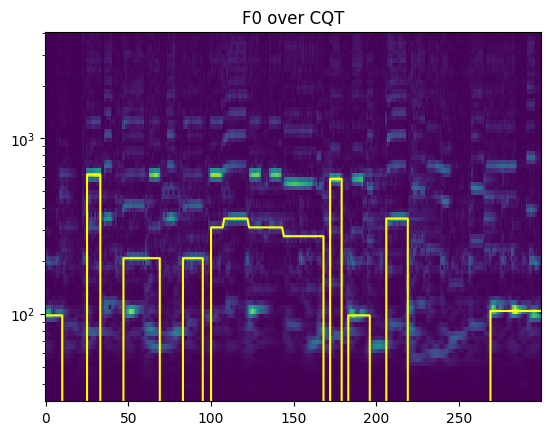

In [66]:
spec = next(iter(E_train.features['cqt']))[0][:,100:400]
x = cqt_frequencies
y = np.arange(spec.shape[1])
xx, yy = np.meshgrid(y, x)
plt.pcolor(xx, yy, spec)
plt.plot(f0[100:400], color='yellow')
plt.yscale('log')
plt.title('F0 over CQT')
plt.show()

In [37]:
# f0 are extracted frequencies, f0_bins are the corresponding bins of CQT, voiced is true if there is a sound playing at the frame.
Extractor.register_mapper(['f0', 'f0_bins', 'voiced'], compute_f0_from_cqt)
Extractor.register_mapper('f0_mean', lambda f0: np.mean(f0))
Extractor.register_mapper('f0_var', lambda f0: np.var(f0))
Extractor.register_mapper('voiced_f0', lambda f0, voiced: f0[voiced], uniform=False)
Extractor.register_mapper('voiced_f0_bins', lambda f0_bins, voiced: f0_bins[voiced], uniform=False)
Extractor.register_mapper('voiced_f0_mean', lambda f0: np.mean(f0))
Extractor.register_mapper('voiced_f0_var', lambda f0: np.var(f0))
Extractor.register_mapper('voiced_percent', lambda voiced: np.mean(voiced))

In [38]:
E_train.soft_extract()

Running extractor for features f0, f0_bins, voiced at 2025-02-17 18:39:55.759341
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.806866 total running time 0:00:17.047525
Running extractor for features f0_mean at 2025-02-17 18:40:12.806955
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.813844 total running time 0:00:00.006889
Running extractor for features voiced_f0_mean at 2025-02-17 18:40:12.813874
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.821122 total running time 0:00:00.007248
Running extractor for features voiced_f0_bins at 2025-02-17 18:40:12.821162


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.865458 total running time 0:00:00.044296
Running extractor for features voiced_percent at 2025-02-17 18:40:12.865488
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.872216 total running time 0:00:00.006728
Running extractor for features voiced_f0_var at 2025-02-17 18:40:12.872243
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.886294 total running time 0:00:00.014051
Running extractor for features f0_var at 2025-02-17 18:40:12.886325
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.899174 total running time 0:00:00.012849
Running extractor for features voiced_f0 at 2025-02-17 18:40:12.899206


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:12.971134 total running time 0:00:00.071928


In [39]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2848200	total: 14.3ms	remaining: 7.14s
100:	learn: 0.8669797	total: 845ms	remaining: 3.34s
200:	learn: 0.9436620	total: 1.66s	remaining: 2.46s
300:	learn: 0.9733959	total: 2.48s	remaining: 1.64s
400:	learn: 0.9874804	total: 3.29s	remaining: 812ms
499:	learn: 0.9953052	total: 4.09s	remaining: 0us
0:	learn: 0.3223787	total: 13.4ms	remaining: 6.67s
100:	learn: 0.8732394	total: 841ms	remaining: 3.32s
200:	learn: 0.9327074	total: 1.65s	remaining: 2.45s
300:	learn: 0.9640063	total: 2.46s	remaining: 1.63s
400:	learn: 0.9827856	total: 3.27s	remaining: 806ms
499:	learn: 0.9921753	total: 4.08s	remaining: 0us
0:	learn: 0.3051643	total: 12.9ms	remaining: 6.43s
100:	learn: 0.8654147	total: 855ms	remaining: 3.38s
200:	learn: 0.9389671	total: 1.67s	remaining: 2.48s
300:	learn: 0.9749609	total: 2.48s	remaining: 1.64s
400:	learn: 0.9859155	total: 3.28s	remaining: 811ms
499:	learn: 0.9953052	total: 4.08s	remaining: 0us
0:	learn: 0.2942097	total: 13.5ms	remaining: 6.76s
100:	learn: 0.8544601	

There is a slight increase in the score

**Overtones:** we shift spectrogram down relative to the bin which corresponds to F0. The idea is that the shape of the chord (eg. minor/major/7-th etc) is determined by the relation of the overtones to the base frequency.

In [40]:
def shift_cqt_by_f0(S: np.ndarray, F0_bins: np.ndarray, voiced: np.ndarray, cqt_frequencies: np.ndarray) -> np.ndarray:
    """
    Shift CQT spectrogram down based on F0 and crop to 40 frequency bins.

    Parameters
    ----------
    S : np.ndarray
        CQT spectrogram, shape (n_freq, n_frames).
    F0 : float
        Fundamental frequency in Hz.
    cqt_frequencies : np.ndarray
        Array of center frequencies for the CQT bins, sorted ascending.

    Returns
    -------
    S_cropped : np.ndarray
        Shifted and cropped CQT spectrogram, shape (40, n_frames).
    """
    # 1. Find which bin is closest to F0
    F0_bins = np.copy(F0_bins)
    F0_bins[~voiced] = 0

    # 2. Shift the spectrogram so that this bin appears near the top
    #    Negative offset rolls elements upward (towards index 0).
    S = np.array([np.roll(frame, -offset) for frame, offset in zip(S.T, F0_bins)]).T
    return S[:40, voiced]

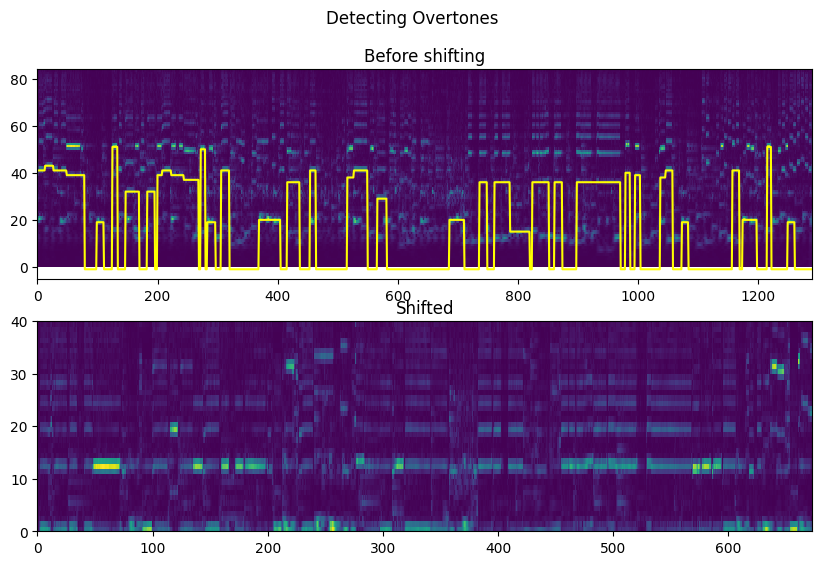

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.suptitle("Detecting Overtones")  # Set the overall title

# First subplot (Before shifting)
plt.subplot(2, 1, 1)
plt.title("Before shifting")
plt.pcolor(next(iter(E_train.features['cqt']))[0])
plt.plot(next(iter(E_train.features['f0_bins']))[0], color='yellow')  # Ensure visibility

# Processing shifted CQT
shifted_cqt = shift_cqt_by_f0(
    next(iter(E_train.features['cqt']))[0],
    next(iter(E_train.features['f0_bins']))[0],
    next(iter(E_train.features['voiced']))[0],
    cqt_frequencies
)

# Second subplot (After shifting)
plt.subplot(2, 1, 2)
plt.title("Shifted")
plt.pcolor(shifted_cqt)

# Show plot
plt.show()


In [42]:
Extractor.register_mapper('overtones', lambda cqt, f0_bins, voiced:
                             shift_cqt_by_f0(cqt, f0_bins, voiced, cqt_frequencies), uniform=False)
Extractor.register_mapper('overtones_freq_mean', lambda overtones:
                             np.mean(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))
Extractor.register_mapper('overtones_freq_var', lambda overtones:
                             np.var(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))

In [43]:
E_train.soft_extract()


Running extractor for features overtones at 2025-02-17 18:40:38.914030


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:44.266123 total running time 0:00:05.352093
Running extractor for features overtones_freq_var at 2025-02-17 18:40:44.266154
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:44.405787 total running time 0:00:00.139633
Running extractor for features overtones_freq_mean at 2025-02-17 18:40:44.405823
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:40:44.524892 total running time 0:00:00.119069


In [44]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'overtones_freq_mean', 'overtones_freq_var']

column_names = E_train.get_columns(features)

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3098592	total: 120ms	remaining: 59.7s
100:	learn: 0.8654147	total: 2.83s	remaining: 11.2s
200:	learn: 0.9405321	total: 5.39s	remaining: 8.03s
300:	learn: 0.9749609	total: 7.97s	remaining: 5.27s
400:	learn: 0.9874804	total: 10.5s	remaining: 2.6s
499:	learn: 0.9953052	total: 13.1s	remaining: 0us
0:	learn: 0.3223787	total: 45.5ms	remaining: 22.7s
100:	learn: 0.8575900	total: 2.75s	remaining: 10.8s
200:	learn: 0.9420970	total: 5.41s	remaining: 8.04s
300:	learn: 0.9671362	total: 8s	remaining: 5.29s
400:	learn: 0.9812207	total: 10.7s	remaining: 2.63s
499:	learn: 0.9859155	total: 13.2s	remaining: 0us
0:	learn: 0.3161189	total: 43.9ms	remaining: 21.9s
100:	learn: 0.8450704	total: 2.75s	remaining: 10.9s
200:	learn: 0.9280125	total: 5.35s	remaining: 7.96s
300:	learn: 0.9687011	total: 7.91s	remaining: 5.23s
400:	learn: 0.9859155	total: 10.5s	remaining: 2.59s
499:	learn: 0.9921753	total: 13s	remaining: 0us
0:	learn: 0.3082942	total: 43.2ms	remaining: 21.6s
100:	learn: 0.8669797	total: 

*Well, this experiment turned out to be unsuccessful*

I tried to capture relative overtones to the current overtone at a time. What if we consider the notes which are most frequent F0s, detect the global key of the sample, and shift all the notes with it. The idea is to try to capture chord sequence (eg. 1-th 4-th 5-th is frequent in rock, while jazz and blues heavily use 6-th and 3-tones)

In [45]:
def f0_chroma_shifted_stats(voiced_f0_bins):
    if voiced_f0_bins.shape[0] == 0:
        return np.zeros((12,)), np.zeros((12,))
    ohe = np.zeros((cqt_frequencies.shape[0], voiced_f0_bins.shape[0]))
    ohe[voiced_f0_bins, np.arange(voiced_f0_bins.shape[0])] = 1
    mean = ohe.mean(axis=-1)
    key = np.argmax(mean)
    key %= 12
    ohe = np.zeros((12, voiced_f0_bins.shape[0]))
    ohe[voiced_f0_bins % 12, np.arange(voiced_f0_bins.shape[0])] = 1
    return (
        np.roll(ohe.mean(axis=-1), -key),
        np.roll(ohe.var(axis=-1), -key),
    )

Extractor.register_mapper(['f0_chroma_shifted_freq_mean', 'f0_chroma_shifted_freq_var'], f0_chroma_shifted_stats)


In [46]:
E_train.soft_extract()

Running extractor for features f0_chroma_shifted_freq_mean, f0_chroma_shifted_freq_var at 2025-02-17 18:42:04.067076
Failed compiling function, will use plain python wrapper, exception: Can't vectorize function with more then one return statement, yet.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 18:42:04.174994 total running time 0:00:00.107918


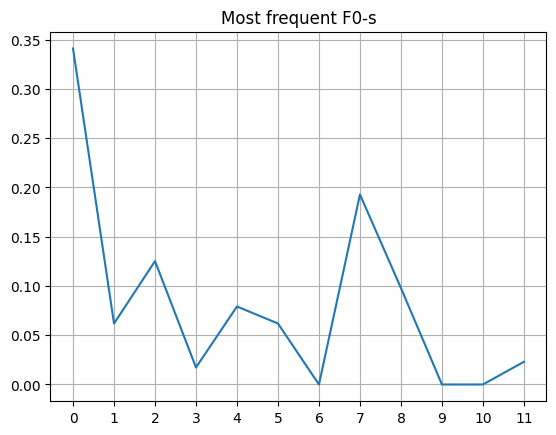

In [91]:
plt.title("Most frequent F0-s")
plt.xticks(np.arange(0, 12, 1.0))
plt.plot(f0_chroma_shifted_stats(E_train.features['voiced_f0_bins']._data[4][0])[0])
plt.grid()

We can see that most frequent is the 7 semitone interval which refers to perfect 5-th which perfectly makes sense

In [48]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'f0_chroma_shifted_freq_mean', 'f0_chroma_shifted_freq_var']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3333333	total: 15ms	remaining: 7.5s
100:	learn: 0.8654147	total: 942ms	remaining: 3.72s
200:	learn: 0.9546166	total: 1.85s	remaining: 2.76s
300:	learn: 0.9780908	total: 2.74s	remaining: 1.81s
400:	learn: 0.9890454	total: 3.63s	remaining: 896ms
499:	learn: 0.9968701	total: 4.51s	remaining: 0us
0:	learn: 0.3270736	total: 14.4ms	remaining: 7.19s
100:	learn: 0.8701095	total: 942ms	remaining: 3.72s
200:	learn: 0.9452269	total: 1.84s	remaining: 2.74s
300:	learn: 0.9671362	total: 2.75s	remaining: 1.82s
400:	learn: 0.9890454	total: 3.64s	remaining: 899ms
499:	learn: 0.9921753	total: 4.51s	remaining: 0us
0:	learn: 0.3082942	total: 14.6ms	remaining: 7.3s
100:	learn: 0.8794992	total: 932ms	remaining: 3.68s
200:	learn: 0.9436620	total: 1.83s	remaining: 2.72s
300:	learn: 0.9765258	total: 2.72s	remaining: 1.8s
400:	learn: 0.9906103	total: 3.63s	remaining: 896ms
499:	learn: 0.9984351	total: 4.51s	remaining: 0us
0:	learn: 0.2832551	total: 14.4ms	remaining: 7.18s
100:	learn: 0.8904538	total

The score got worse but lets check feature importance

In [49]:
pd.DataFrame(
    data=model.feature_importances_,
    index=np.array(E_train.get_columns(features))[mask],
    columns=['importance']
).sort_values('importance', ascending=False).head(30)

,importance
mfcc_quef_mean_3,3.254400
bandwidth_mean,3.069062
mfcc_quef_var_4,2.931473
cqt_harmonic_freq_var_10,2.365524
mfcc_quef_mean_5,2.317102
cqt_percussive_freq_var_33,1.996789
mel48_freq_var_35,1.830703
cqt_harmonic_freq_var_33,1.824305
cqt_percussive_freq_mean_19,1.783911
cqt_percussive_freq_var_25,1.507354


In [50]:
new = E_train.get_columns(['f0_chroma_shifted_freq_mean', 'f0_chroma_shifted_freq_var'])
pd.DataFrame(
    data=model.feature_importances_,
    index=np.array(E_train.get_columns(features))[mask],
    columns=['importance']
).loc[new]

,importance
f0_chroma_shifted_freq_mean_0,0.340320
f0_chroma_shifted_freq_mean_1,0.094853
f0_chroma_shifted_freq_mean_2,0.049555
f0_chroma_shifted_freq_mean_3,0.000315
f0_chroma_shifted_freq_mean_4,0.028165
f0_chroma_shifted_freq_mean_5,1.090288
f0_chroma_shifted_freq_mean_6,0.183776
f0_chroma_shifted_freq_mean_7,0.602871
f0_chroma_shifted_freq_mean_8,0.065165
f0_chroma_shifted_freq_mean_9,0.005917


Features `f0_chroma_shifted_freq_mean_5` and `f0_chroma_shifted_freq_mean_7` corresponding to perfect 4-th and 5-th seem to be important. Maybe leaving only them will work?

In [93]:
# Blacklist all except 'f0_chroma_shifted_freq_mean_5', 'f0_chroma_shifted_freq_mean_7'
bad_feats += list(set(new) - {'f0_chroma_shifted_freq_mean_5', 'f0_chroma_shifted_freq_mean_7'})

In [52]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2848200	total: 15.3ms	remaining: 7.61s
100:	learn: 0.8669797	total: 914ms	remaining: 3.61s
200:	learn: 0.9436620	total: 1.82s	remaining: 2.71s
300:	learn: 0.9733959	total: 2.73s	remaining: 1.8s
400:	learn: 0.9874804	total: 3.64s	remaining: 899ms
499:	learn: 0.9953052	total: 4.53s	remaining: 0us
0:	learn: 0.3223787	total: 13.8ms	remaining: 6.9s
100:	learn: 0.8732394	total: 848ms	remaining: 3.35s
200:	learn: 0.9327074	total: 1.66s	remaining: 2.47s
300:	learn: 0.9640063	total: 2.47s	remaining: 1.63s
400:	learn: 0.9827856	total: 3.28s	remaining: 810ms
499:	learn: 0.9921753	total: 4.07s	remaining: 0us
0:	learn: 0.3051643	total: 13.2ms	remaining: 6.57s
100:	learn: 0.8654147	total: 873ms	remaining: 3.45s
200:	learn: 0.9389671	total: 1.71s	remaining: 2.54s
300:	learn: 0.9749609	total: 2.52s	remaining: 1.67s
400:	learn: 0.9859155	total: 3.33s	remaining: 822ms
499:	learn: 0.9953052	total: 4.12s	remaining: 0us
0:	learn: 0.2942097	total: 13.3ms	remaining: 6.63s
100:	learn: 0.8544601	to

*All the experiments with overtones and F0 progression failed, lets go back to previous set of features*

## Tempo

Lets try extracting tempo features. We calculate the tempogram that is autocorrelation of onset spectrogram in short windows. We calculate it over the whole frequency range and only over frequency bands. The mel spectrogram is used to compute offsets.

Then using the tempogram the tempogram ratio is calculate that is the energy at the common music intervals

Drums can indeed be divided into frequency classes based on their tonal characteristics. Here are the approximate frequency boundaries for these classes:

    Kick drums: 50-100 Hz for the fundamental frequency37
    Floor toms: 60-110 Hz7

    Snare drums: 200-250 Hz for the fundamental frequency, with presence extending up to 4 kHz
    Regular toms: 100-600 Hz7

    Hi-hats: 300 Hz - 17 kHz, with most of the characteristic "sizzle" around 7 kHz and above
    Cymbals: Generally above 8 kH

In [94]:
low_to_mid_hz=150
mid_to_high_hz=2000

def onsets_tempograms_per_band_and_global(mel):
    """
    Compute both global (single-band) and per-band (multi-band) onset envelopes
    and tempograms using custom frequency boundaries.

    Parameters
    ----------
    mel : np.ndarray [shape=(n_mels, t)]
        Mel spectrogram.
    sr : int
        Sampling rate of the audio.
    low_to_mid_hz : float
        Lower boundary between "low" and "mid" frequency ranges.
    mid_to_high_hz : float
        Upper boundary between "mid" and "high" frequency ranges.
    fmax : float or None
        Maximum frequency for global onset calculation. If None, defaults to sr/2.

    Returns
    -------
    results : dict
        A dictionary with the following keys:
          "onset_env_global" : np.ndarray [shape=(t,)]
              Global onset envelope (all frequencies)
          "tempogram_global" : np.ndarray [shape=(win_length/2+1, t)]
              Tempogram from the global onset envelope
          "onset_env_multi"  : np.ndarray [shape=(num_bands, t)]
              Per-band onset envelopes
          "tempograms_multi" : list of np.ndarray
              List of tempograms, one per frequency band
          "channels"         : list of np.ndarray
              Indices of the mel bins that compose each frequency band
    """

    # --- 1) Determine mel-bin frequencies and find boundary indices ---
    n_mels = mel.shape[0]
    mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmax=fmax)

    # Find where 150 Hz and 2000 Hz should be inserted to maintain sorted order
    boundary_low_mid = np.searchsorted(mel_frequencies, low_to_mid_hz)
    boundary_mid_high = np.searchsorted(mel_frequencies, mid_to_high_hz)

    # Define three custom bands: [0..150 Hz], [150..2000 Hz], [2000..fmax]
    channels = [
        0, boundary_low_mid, boundary_mid_high, n_mels
    ]

    # --- 2) Calculate per-band (multi-band) onset envelopes ---
    onset_env_multi = librosa.onset.onset_strength_multi(
        S=mel,
        sr=sr,
        channels=channels,
        fmax=fmax
    )

    # --- 3) Calculate per-band tempograms ---
    tempograms_multi = [
        librosa.feature.tempogram(onset_envelope=band_env, sr=sr)
        for band_env in onset_env_multi
    ]

    # --- 4) Calculate global (single-band) onset envelope + tempogram ---
    onset_env_global = librosa.onset.onset_strength(S=mel, sr=sr, fmax=fmax)
    tempogram_global = librosa.feature.tempogram(onset_envelope=onset_env_global, sr=sr)

    # --- 5) Package up results ---
    return (
        onset_env_global,
        tempogram_global,
        np.array(onset_env_multi),
        np.array(tempograms_multi),
    )

Extractor.register_mapper(["onset", "tempogram", "onset_channel", "tempogram_channel"], onsets_tempograms_per_band_and_global)

In [95]:
E_train.soft_extract()

Running extractor for features onset, tempogram, onset_channel, tempogram_channel at 2025-02-17 22:22:27.687956
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:24:09.193384 total running time 0:01:41.505428


In [97]:
Extractor.register_mapper('tempogram_tempo_mean', lambda tempogram: tempogram.mean(axis=-1))
Extractor.register_mapper('tempogram_tempo_var', lambda tempogram: tempogram.var(axis=-1))
Extractor.register_mapper('tempogram_ratio', lambda tempogram: librosa.feature.tempogram_ratio(tg=tempogram, sr=sr))
Extractor.register_mapper('tempogram_ratio_tempo_mean', lambda tempogram_ratio: tempogram_ratio.mean(axis=-1))
Extractor.register_mapper('tempogram_ratio_tempo_var', lambda tempogram_ratio: tempogram_ratio.var(axis=-1))
E_train.soft_extract()

Running extractor for features tempogram_ratio at 2025-02-17 22:24:24.019905
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:24:52.457994 total running time 0:00:28.438089
Running extractor for features tempogram_ratio_tempo_mean at 2025-02-17 22:24:52.458107
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:24:52.486796 total running time 0:00:00.028689
Running extractor for features tempogram_ratio_tempo_var at 2025-02-17 22:24:52.486837
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:24:52.517191 total running time 0:00:00.030354
Running extractor for features tempogram_tempo_mean at 2025-02-17 22:24:52.517294
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:24:52.845586 total running time 0:00:00.328292
Running extractor for features tempogram_tempo_var at 2025-02-17 22:24:52.845675
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:24:53.331061 total running time 0:00:00.485386


**Lets try only the global tempogram first**

In [201]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2910798	total: 21.6ms	remaining: 10.8s
100:	learn: 0.8873239	total: 1.01s	remaining: 3.99s
200:	learn: 0.9530516	total: 2.14s	remaining: 3.19s
300:	learn: 0.9765258	total: 3.16s	remaining: 2.09s
400:	learn: 0.9921753	total: 4.11s	remaining: 1.01s
499:	learn: 0.9984351	total: 5.08s	remaining: 0us
0:	learn: 0.3176839	total: 15.3ms	remaining: 7.63s
100:	learn: 0.8873239	total: 998ms	remaining: 3.94s
200:	learn: 0.9452269	total: 1.96s	remaining: 2.91s
300:	learn: 0.9718310	total: 2.83s	remaining: 1.87s
400:	learn: 0.9827856	total: 3.69s	remaining: 912ms
499:	learn: 0.9921753	total: 4.56s	remaining: 0us
0:	learn: 0.2347418	total: 15.1ms	remaining: 7.53s
100:	learn: 0.8888889	total: 909ms	remaining: 3.59s
200:	learn: 0.9483568	total: 1.79s	remaining: 2.66s
300:	learn: 0.9796557	total: 2.66s	remaining: 1.76s
400:	learn: 0.9937402	total: 3.57s	remaining: 882ms
499:	learn: 0.9968701	total: 4.44s	remaining: 0us
0:	learn: 0.2738654	total: 14.8ms	remaining: 7.41s
100:	learn: 0.8857590	

**Now lets calculate the features per-channel**

In [98]:
Extractor.register_mapper('tempogram_ratio_channel', lambda tempogram_channel: np.array([librosa.feature.tempogram_ratio(tg=chan, sr=sr) for chan in tempogram_channel]))
Extractor.register_mapper('tempogram_ratio_channel_tempo_mean', lambda tempogram_ratio_channel: tempogram_ratio_channel.mean(axis=-1))
Extractor.register_mapper('tempogram_ratio_channel_tempo_var', lambda tempogram_ratio_channel: tempogram_ratio_channel.var(axis=-1))

In [99]:
E_train.soft_extract()

Running extractor for features tempogram_ratio_channel at 2025-02-17 22:25:16.147703
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:27:08.112337 total running time 0:01:51.964634
Running extractor for features tempogram_ratio_channel_tempo_var at 2025-02-17 22:27:08.119995
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:27:08.642590 total running time 0:00:00.522595
Running extractor for features tempogram_ratio_channel_tempo_mean at 2025-02-17 22:27:08.642713
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:27:08.666034 total running time 0:00:00.023321


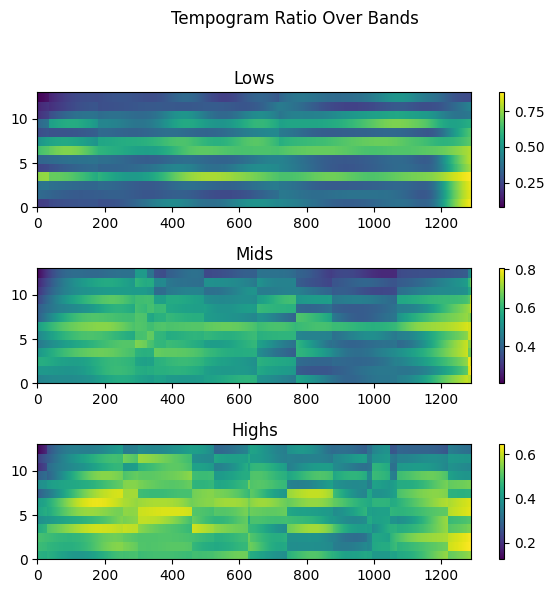

In [109]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(6, 6))  # Adjust height for better spacing
plt.suptitle("Tempogram Ratio Over Bands")  # Overall title

# Extract data for better readability
tempogram_data = E_train.features['tempogram_ratio_channel']._data[0][0]

# First subplot (Lows)
plt.subplot(3, 1, 1)
plt.title("Lows")
plt.pcolor(tempogram_data[0])
plt.colorbar()  # Optional: Adds a color scale for better visualization

# Second subplot (Mids)
plt.subplot(3, 1, 2)
plt.title("Mids")
plt.pcolor(tempogram_data[1])
plt.colorbar()

# Third subplot (Highs)
plt.subplot(3, 1, 3)
plt.title("Highs")
plt.pcolor(tempogram_data[2])
plt.colorbar()

# Adjust layout for better visibility
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Prevent overlap with suptitle

# Show the plot
plt.show()


In [279]:
features = ['rms', 'bpm', 
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var',
    'tempogram_ratio_channel_tempo_mean', 'tempogram_ratio_channel_tempo_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3427230	total: 22.3ms	remaining: 11.1s
100:	learn: 0.8998435	total: 1.29s	remaining: 5.08s
200:	learn: 0.9624413	total: 2.53s	remaining: 3.77s
300:	learn: 0.9796557	total: 3.67s	remaining: 2.42s
400:	learn: 0.9953052	total: 4.82s	remaining: 1.19s
499:	learn: 0.9984351	total: 5.94s	remaining: 0us
0:	learn: 0.3302034	total: 18.9ms	remaining: 9.44s
100:	learn: 0.8935837	total: 1.19s	remaining: 4.68s
200:	learn: 0.9624413	total: 2.35s	remaining: 3.49s
300:	learn: 0.9780908	total: 3.48s	remaining: 2.3s
400:	learn: 0.9906103	total: 4.61s	remaining: 1.14s
499:	learn: 0.9921753	total: 5.72s	remaining: 0us
0:	learn: 0.3427230	total: 18.9ms	remaining: 9.45s
100:	learn: 0.9045383	total: 1.18s	remaining: 4.66s
200:	learn: 0.9577465	total: 2.32s	remaining: 3.44s
300:	learn: 0.9843505	total: 3.46s	remaining: 2.29s
400:	learn: 0.9921753	total: 4.58s	remaining: 1.13s
499:	learn: 0.9984351	total: 5.73s	remaining: 0us
0:	learn: 0.3051643	total: 19.2ms	remaining: 9.57s
100:	learn: 0.8920188	t

*Wow, finally significant increase in the score*

## Spectral contrast

Spectral contrast corresponds to *clearness* of sound.

For each band (consisting of stft bins) and each frame the top quantile bins and a bottom quantile bins are selected. Then the mean energy in the selected bins is calculated and compared

In [110]:
n_bands=6
spectral_contrast_quantile=0.02
Extractor.register_mapper("spectral_contrast", 
                         lambda stft: librosa.feature.spectral_contrast(sr=22050, S=stft, n_fft=n_fft, 
                                       hop_length=hop_length, fmin=fmin, n_bands=n_bands, quantile=spectral_contrast_quantile))
Extractor.register_mapper("spectral_contrast_band_mean", 
                         lambda spectral_contrast: spectral_contrast.mean(axis=1))
Extractor.register_mapper("spectral_contrast_band_var", 
                         lambda spectral_contrast: spectral_contrast.var(axis=1))

In [111]:
E_train.soft_extract()

Running extractor for features spectral_contrast at 2025-02-17 22:37:05.813293
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:38:02.381727 total running time 0:00:56.568434
Running extractor for features spectral_contrast_band_mean at 2025-02-17 22:38:02.381868
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:38:02.404857 total running time 0:00:00.022989
Running extractor for features spectral_contrast_band_var at 2025-02-17 22:38:02.404968
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:38:02.428120 total running time 0:00:00.023152


In [113]:
features = ['rms', 'bpm', 
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var',
    'tempogram_ratio_channel_tempo_mean', 'tempogram_ratio_channel_tempo_var',
    'spectral_contrast_band_mean', 'spectral_contrast_band_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3161189	total: 65.4ms	remaining: 32.6s
100:	learn: 0.8951487	total: 1.56s	remaining: 6.18s
200:	learn: 0.9530516	total: 2.91s	remaining: 4.33s
300:	learn: 0.9843505	total: 4.17s	remaining: 2.75s
400:	learn: 0.9937402	total: 5.42s	remaining: 1.34s
499:	learn: 0.9984351	total: 6.8s	remaining: 0us
0:	learn: 0.3208138	total: 20.6ms	remaining: 10.3s
100:	learn: 0.9014085	total: 1.36s	remaining: 5.38s
200:	learn: 0.9436620	total: 2.82s	remaining: 4.2s
300:	learn: 0.9702660	total: 4.07s	remaining: 2.69s
400:	learn: 0.9890454	total: 5.5s	remaining: 1.36s
499:	learn: 0.9968701	total: 6.84s	remaining: 0us
0:	learn: 0.3208138	total: 22.1ms	remaining: 11s
100:	learn: 0.9014085	total: 1.37s	remaining: 5.41s
200:	learn: 0.9640063	total: 2.76s	remaining: 4.11s
300:	learn: 0.9812207	total: 4.13s	remaining: 2.73s
400:	learn: 0.9937402	total: 5.52s	remaining: 1.36s
499:	learn: 0.9937402	total: 6.79s	remaining: 0us
0:	learn: 0.2754304	total: 20.7ms	remaining: 10.3s
100:	learn: 0.8967136	total

Lets try to experiment with onset strength (or spectral flux)

In [112]:
Extractor.register_mapper("onset_mean", 
                         lambda onset: onset.mean())
Extractor.register_mapper("onset_var", 
                         lambda onset: onset.var())
E_train.soft_extract()

Running extractor for features onset_var at 2025-02-17 22:38:09.632520
Failed compiling function, will use plain python wrapper.


  0%|          | 0/2 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:38:09.664766 total running time 0:00:00.032246
Running extractor for features onset_mean at 2025-02-17 22:38:09.664832
Failed compiling function, will use plain python wrapper.


  0%|          | 0/2 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:38:09.677985 total running time 0:00:00.013153


In [297]:
features = ['rms', 'bpm', 
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var',
    'tempogram_ratio_channel_tempo_mean', 'tempogram_ratio_channel_tempo_var',
    'spectral_contrast_band_mean', 'spectral_contrast_band_var',
    'onset_mean', 'onset_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3489828	total: 27.2ms	remaining: 13.6s
100:	learn: 0.9045383	total: 1.44s	remaining: 5.7s
200:	learn: 0.9687011	total: 2.88s	remaining: 4.29s
300:	learn: 0.9890454	total: 4.22s	remaining: 2.79s
400:	learn: 0.9953052	total: 5.44s	remaining: 1.34s
499:	learn: 0.9984351	total: 6.64s	remaining: 0us
0:	learn: 0.3630673	total: 19.7ms	remaining: 9.83s
100:	learn: 0.9170579	total: 1.22s	remaining: 4.81s
200:	learn: 0.9624413	total: 2.4s	remaining: 3.57s
300:	learn: 0.9718310	total: 3.56s	remaining: 2.36s
400:	learn: 0.9890454	total: 4.75s	remaining: 1.17s
499:	learn: 0.9953052	total: 5.9s	remaining: 0us
0:	learn: 0.3161189	total: 19.1ms	remaining: 9.54s
100:	learn: 0.8998435	total: 1.23s	remaining: 4.85s
200:	learn: 0.9577465	total: 2.41s	remaining: 3.58s
300:	learn: 0.9765258	total: 3.57s	remaining: 2.36s
400:	learn: 0.9890454	total: 4.76s	remaining: 1.17s
499:	learn: 0.9984351	total: 5.94s	remaining: 0us
0:	learn: 0.2769953	total: 20.7ms	remaining: 10.3s
100:	learn: 0.8951487	tot

## Feature and hyperparameter selection

1. We train the model on the optimal by far set of parameters again
2. Compute correlation and importance of parameters
3. Throw the parameters which are too much correlated and parameters with too low importance
4. Use auto-ML framework optuna to select hyperparameters for catboost and thresholds our feature selection algorithm

0:	learn: 0.3161189	total: 47.3ms	remaining: 23.6s
100:	learn: 0.8951487	total: 1.31s	remaining: 5.19s
200:	learn: 0.9530516	total: 2.58s	remaining: 3.83s
300:	learn: 0.9843505	total: 3.75s	remaining: 2.48s
400:	learn: 0.9937402	total: 4.93s	remaining: 1.22s
499:	learn: 0.9984351	total: 6.1s	remaining: 0us
0:	learn: 0.3208138	total: 19.8ms	remaining: 9.89s
100:	learn: 0.9014085	total: 1.25s	remaining: 4.92s
200:	learn: 0.9436620	total: 2.45s	remaining: 3.64s
300:	learn: 0.9702660	total: 3.86s	remaining: 2.55s
400:	learn: 0.9890454	total: 5.05s	remaining: 1.25s
499:	learn: 0.9968701	total: 6.27s	remaining: 0us
0:	learn: 0.3208138	total: 20.3ms	remaining: 10.1s
100:	learn: 0.9014085	total: 1.25s	remaining: 4.92s
200:	learn: 0.9640063	total: 2.53s	remaining: 3.76s
300:	learn: 0.9812207	total: 3.79s	remaining: 2.51s
400:	learn: 0.9937402	total: 5.04s	remaining: 1.24s
499:	learn: 0.9937402	total: 6.26s	remaining: 0us
0:	learn: 0.2754304	total: 20.5ms	remaining: 10.2s
100:	learn: 0.8967136	t

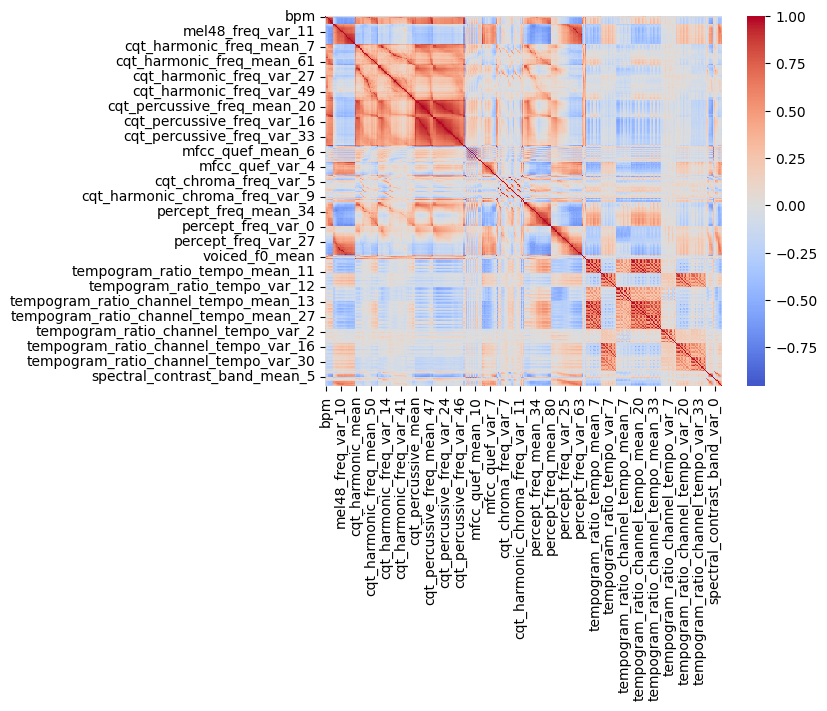

,importance
bpm,0.032764
mel48_freq_mean_6,0.018702
mel48_freq_mean_19,0.001294
mel48_freq_mean_22,0.142164
mel48_freq_mean_30,0.000543
...,...
spectral_contrast_band_var_2,0.066869
spectral_contrast_band_var_3,0.120984
spectral_contrast_band_var_4,0.010480
spectral_contrast_band_var_5,0.162784


In [116]:
# Train a good model once again
import seaborn as sns

features = ['rms', 'bpm', 
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var',
    'tempogram_ratio_channel_tempo_mean', 'tempogram_ratio_channel_tempo_var',
    'spectral_contrast_band_mean', 'spectral_contrast_band_var'
    ]

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

feat = E_train[features].loc[:,mask]
corr_matrix = feat.corr(method='spearman')  # or 'spearman'
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.show()

imp = pd.DataFrame(
    data=model.feature_importances_,
    index=np.array(column_names)[mask],
    columns=['importance']
)

imp

*As we can see some features are extremely correlated*

In [118]:
# The algorithm goes from the most important feature to the least and takes 
# feature if it importance is bove the thresholdm and if it is not correlated too much with already selected features.

def select_features_greedy(importances: pd.DataFrame,
                           corr_matrix: pd.DataFrame,
                           corr_threshold: float = 0.9,
                           imp_threshold: float = 0.1) -> list:
    """
    Perform greedy feature selection by sorting features by CatBoost importance
    and discarding any feature that has absolute correlation above `corr_threshold`
    with any already-selected feature.
    
    :param importances: DataFrame with columns ["feature", "importance"].
    :param corr_matrix: Spearman correlation matrix (DataFrame) with feature names as rows & columns.
    :param corr_threshold: Threshold above which we consider two features too highly correlated.
    :return: List of selected feature names in the order they were chosen.
    """
    
    # 1. Sort features by descending importance
    sorted_importances = importances.sort_values(by="importance", ascending=False)
    
    selected_features = []
    
    # 2. Greedily add features if they are not too correlated with already chosen ones
    for feat in sorted_importances.index:
        if sorted_importances.loc[feat, 'importance'] < imp_threshold:
            break
        keep_feature = True
        
        for chosen_feat in selected_features:
            # Check absolute correlation
            if abs(corr_matrix.loc[feat, chosen_feat]) > corr_threshold:
                keep_feature = False
                break
        
        if keep_feature:
            selected_features.append(feat)
    
    return selected_features

selected_features = select_features_greedy(imp, corr_matrix, 0.9, 0.1)


In [119]:
features = ['rms', 'bpm', 
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var',
    'tempogram_ratio_channel_tempo_mean', 'tempogram_ratio_channel_tempo_var',
    'spectral_contrast_band_mean', 'spectral_contrast_band_var',
    ]

column_names = E_train.get_columns(features)

mask = [f in selected_features for f in column_names]

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2801252	total: 8.75ms	remaining: 4.37s
100:	learn: 0.9092332	total: 501ms	remaining: 1.98s
200:	learn: 0.9640063	total: 979ms	remaining: 1.46s
300:	learn: 0.9827856	total: 1.5s	remaining: 992ms
400:	learn: 0.9921753	total: 1.96s	remaining: 483ms
499:	learn: 0.9984351	total: 2.42s	remaining: 0us
0:	learn: 0.2942097	total: 7.72ms	remaining: 3.85s
100:	learn: 0.9107981	total: 522ms	remaining: 2.06s
200:	learn: 0.9530516	total: 1.05s	remaining: 1.57s
300:	learn: 0.9827856	total: 1.59s	remaining: 1.05s
400:	learn: 0.9906103	total: 2.12s	remaining: 524ms
499:	learn: 0.9968701	total: 2.58s	remaining: 0us
0:	learn: 0.3192488	total: 7.77ms	remaining: 3.88s
100:	learn: 0.9092332	total: 460ms	remaining: 1.82s
200:	learn: 0.9718310	total: 910ms	remaining: 1.35s
300:	learn: 0.9843505	total: 1.36s	remaining: 900ms
400:	learn: 0.9921753	total: 1.83s	remaining: 452ms
499:	learn: 0.9984351	total: 2.27s	remaining: 0us
0:	learn: 0.2566510	total: 7.67ms	remaining: 3.83s
100:	learn: 0.9029734	t

*we get slightly weaker result, but we haven't yet employed optuna*

## AutoML
The idea is that we want to run throughout all hyperparameter space to chose the best ones. But it will take increasingly large amount of time. So what we can do is to use some (fast to run) regression algorihms to estimate the value of the loss at the given point. As there are few datapoints with few labels, and in the meantime the dependency might be non-linear usually something like Kernel-SVM is used.

![Estimation the possible surface of the score with few points](newplot(3).png)
  
*Estimation the possible surface of the score with few points*

In [395]:
import optuna

# Train model without masking
features = ['rms', 'bpm', 
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var',
    'tempogram_ratio_channel_tempo_mean', 'tempogram_ratio_channel_tempo_var',
    'spectral_contrast_band_mean', 'spectral_contrast_band_var',
    ]

column_names = E_train.get_columns(features)

X_train_feats = E_train.numpy(features)

def objective(trial):
    """
    Optuna objective function:
    1. Samples corr_threshold, imp_threshold, and CatBoost hyperparameters.
    2. Selects features using greedy feature selection.
    3. Trains and evaluates CatBoost with these features + hyperparams using CV.
    4. Returns the mean validation metric (e.g., accuracy).
    """
    
    # --- 1. Hyperparameter search space ---
    corr_threshold = trial.suggest_float("corr_threshold", 0.70, 0.99, step=0.01)
    imp_threshold  = trial.suggest_float("imp_threshold", 0.0, 0.5, step=0.01)
    
    # CatBoost hyperparameters
    learning_rate      = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    depth              = trial.suggest_int("depth", 3, 10)
    bagging_temperature= trial.suggest_float("bagging_temperature", 0.5, 2.0)
    l2_leaf_reg        = trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
    random_strength    = trial.suggest_float("random_strength", 0.0, 10.0)
    
    # You can add more CatBoost parameters if desired
    # e.g. 'subsample', 'rsm', 'grow_policy', etc.

    # --- 2. Feature Selection ---
    # Use the function defined above to select features
    selected_features = select_features_greedy(
        importances=imp,   # <-- your df: columns [feature, importance]
        corr_matrix=corr_matrix,       # <-- your Spearman corr matrix (features x features)
        corr_threshold=corr_threshold,
        imp_threshold=imp_threshold,
    )
    
    # If too few features end up selected, we can gracefully handle that:
    if len(selected_features) < 2:
        # Return poor score or skip
        return 0.0  # or return trial.set_user_attr('too_few_feats', True)

    mask = [f in selected_features for f in column_names]
    # Subset your data to these features
    X_sel = X_train_feats[:, mask]  # X is your full dataframe of features

    _, score = train_and_evaluate_catboost(X_sel, y_train.to_numpy(), verbose=False, train_final=False,
                               learning_rate=learning_rate,
                               depth=depth,
                               bagging_temperature=bagging_temperature,
                               l2_leaf_reg=l2_leaf_reg,
                               random_strength=random_strength)
    
    return score


    study = optuna.create_study(direction="maximize", storage="sqlite:///optuna.db")
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Best trial:")
    print(f"  Value (CV accuracy): {study.best_trial.value}")
    print("  Params: ")
    for key, val in study.best_trial.params.items():
        print(f"    {key}: {val}")


In [396]:
# Running this cell takes several hours, so I don't rerun it now, but I will provide screenshots to show learning process
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna.db")
study.enqueue_trial(dict(
    learning_rate=0.1,
    depth=3,
    bagging_temperature=1,
    l2_leaf_reg=3,
    random_strength=1,
    imp_threshold=0.1,
    corr_threshold=0.9,
))
study.optimize(objective, n_trials=50, show_progress_bar=True)
print("Best trial:")
print(f"  Value (CV accuracy): {study.best_trial.value}")
print("  Params: ")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-02-15 12:30:38,312] A new study created in RDB with name: no-name-12ac4561-bc76-4533-8b25-e43d11529182


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-15 12:30:50,901] Trial 0 finished with value: 0.8097798742138365 and parameters: {'corr_threshold': 0.9, 'imp_threshold': 0.1, 'learning_rate': 0.1, 'depth': 3, 'bagging_temperature': 1.0, 'l2_leaf_reg': 3.0, 'random_strength': 1.0}. Best is trial 0 with value: 0.8097798742138365.
[I 2025-02-15 12:33:23,057] Trial 1 finished with value: 0.8009984276729559 and parameters: {'corr_threshold': 0.8999999999999999, 'imp_threshold': 0.37, 'learning_rate': 0.16407237935405106, 'depth': 8, 'bagging_temperature': 1.7160679588961654, 'l2_leaf_reg': 1.0030984524708204, 'random_strength': 5.709038973491073}. Best is trial 0 with value: 0.8097798742138365.
[I 2025-02-15 12:34:08,423] Trial 2 finished with value: 0.7459433962264151 and parameters: {'corr_threshold': 0.71, 'imp_threshold': 0.31, 'learning_rate': 0.020573825848936113, 'depth': 7, 'bagging_temperature': 0.9908993124349488, 'l2_leaf_reg': 8.59715472407786, 'random_strength': 8.234696688253788}. Best is trial 0 with value: 0.80

In [401]:
from copy import copy
catboost_params = copy(study.best_params)
del catboost_params['corr_threshold']
del catboost_params['imp_threshold']
feat_selection_params = {
    corr_threshold: study.best_params['corr_threshold'],
    imp_threshold: study.best_params['imp_threshold']
}

In [121]:
# Run this if you don't want to re-run optuna

catboost_params = {
    "learning_rate": 0.25988113627603726,
    "depth": 3,
    "bagging_temperature": 1.53898553722534,
    "l2_leaf_reg": 1.2081936921122722,
    "random_strength": 8.391328636613988,
}
feat_selection_params = {
    "corr_threshold": 0.98,
    "imp_threshold": 0.11
}

In [122]:
selected_features = select_features_greedy(
    importances=imp,
    corr_matrix=corr_matrix,
    corr_threshold=feat_selection_params['corr_threshold'],
    imp_threshold=feat_selection_params['imp_threshold'],
)

In [123]:
features = ['rms', 'bpm', 
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'tempogram_ratio_tempo_mean', 'tempogram_ratio_tempo_var',
    'tempogram_ratio_channel_tempo_mean', 'tempogram_ratio_channel_tempo_var',
    'spectral_contrast_band_mean', 'spectral_contrast_band_var',
    ]

column_names = E_train.get_columns(features)

mask = [f in selected_features for f in column_names]

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
    **catboost_params
)

0:	learn: 0.2566510	total: 27.8ms	remaining: 13.9s
100:	learn: 0.9812207	total: 677ms	remaining: 2.67s
200:	learn: 1.0000000	total: 1.41s	remaining: 2.1s
300:	learn: 1.0000000	total: 2.05s	remaining: 1.35s
400:	learn: 1.0000000	total: 2.65s	remaining: 654ms
499:	learn: 1.0000000	total: 3.36s	remaining: 0us
0:	learn: 0.2957746	total: 10.4ms	remaining: 5.2s
100:	learn: 0.9827856	total: 722ms	remaining: 2.85s
200:	learn: 0.9984351	total: 1.34s	remaining: 1.99s
300:	learn: 0.9984351	total: 1.93s	remaining: 1.27s
400:	learn: 0.9984351	total: 2.54s	remaining: 628ms
499:	learn: 0.9984351	total: 3.18s	remaining: 0us
0:	learn: 0.3051643	total: 11.5ms	remaining: 5.74s
100:	learn: 0.9702660	total: 677ms	remaining: 2.67s
200:	learn: 0.9984351	total: 1.33s	remaining: 1.98s
300:	learn: 0.9984351	total: 1.93s	remaining: 1.27s
400:	learn: 0.9984351	total: 2.52s	remaining: 623ms
499:	learn: 0.9984351	total: 3.12s	remaining: 0us
0:	learn: 0.2316119	total: 10.6ms	remaining: 5.27s
100:	learn: 0.9577465	to

## Evaluation
Now let's check the score on hold-out set

In [124]:
E_eval.soft_extract()

Running extractor for features audio at 2025-02-17 22:56:54.890114
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:56:55.804112 total running time 0:00:00.913998
Running extractor for features complex_cqt at 2025-02-17 22:56:55.804155
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:56:59.644672 total running time 0:00:03.840517
Running extractor for features cqt at 2025-02-17 22:56:59.644704


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:56:59.682985 total running time 0:00:00.038281
Running extractor for features cqt_harmonic, cqt_percussive at 2025-02-17 22:56:59.683017
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:15.016522 total running time 0:00:15.333505
Running extractor for features cqt_harmonic_chroma at 2025-02-17 22:57:15.016555
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:15.303183 total running time 0:00:00.286628
Running extractor for features cqt_harmonic_tonnenz at 2025-02-17 22:57:15.305921
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:15.384127 total running time 0:00:00.078206
Running extractor for features cqt_harmonic_tonnenz_channel_var at 2025-02-17 22:57:15.384236
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:15.412595 total running time 0:00:00.028359
Running extractor for features f0, f0_bins, voiced at 2025-02-17 22:57:15.412866
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:19.342193 total running time 0:00:03.929327
Running extractor for features complex_stft at 2025-02-17 22:57:19.342226
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:21.612543 total running time 0:00:02.270317
Running extractor for features stft at 2025-02-17 22:57:21.612630


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:22.352402 total running time 0:00:00.739772
Running extractor for features mel at 2025-02-17 22:57:22.352450
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:23.861618 total running time 0:00:01.509168
Running extractor for features onset, tempogram, onset_channel, tempogram_channel at 2025-02-17 22:57:23.861686
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:33.206792 total running time 0:00:09.345106
Running extractor for features onset_var at 2025-02-17 22:57:33.207049
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:33.215781 total running time 0:00:00.008732
Running extractor for features f0_mean at 2025-02-17 22:57:33.215839
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:33.222852 total running time 0:00:00.007013
Running extractor for features stft_var at 2025-02-17 22:57:33.222919
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:33.680750 total running time 0:00:00.457831
Running extractor for features percept at 2025-02-17 22:57:33.680817
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:33.836470 total running time 0:00:00.155653
Running extractor for features percept_mean at 2025-02-17 22:57:33.837921
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 22:57:33.857557 total running time 0:00:00.019636
Running extractor for features stft_harmonic, stft_percussive at 2025-02-17 22:57:33.857631
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:00:49.565359 total running time 0:03:15.707728
Running extractor for features stft_harmonic_mean, stft_harmonic_var, stft_percussive_mean, stft_percussive_var, mel_harmonic, mel_percussive at 2025-02-17 23:00:49.567138
Failed compiling function, will use plain python wrapper, exception: tuple index out of range


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:00:52.253767 total running time 0:00:02.686629
Running extractor for features zero_crossing_rate at 2025-02-17 23:00:52.253914
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:00:55.095984 total running time 0:00:02.842070
Running extractor for features zero_crossing_rate_var at 2025-02-17 23:00:55.097125
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:00:55.107842 total running time 0:00:00.010717
Running extractor for features tempogram_ratio at 2025-02-17 23:00:55.108270
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:00.028214 total running time 0:00:04.919944
Running extractor for features tempogram_ratio_tempo_mean at 2025-02-17 23:01:00.028404
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:00.050496 total running time 0:00:00.022092
Running extractor for features tempogram_ratio_tempo_var at 2025-02-17 23:01:00.051002
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:00.083600 total running time 0:00:00.032598
Running extractor for features cqt_chroma at 2025-02-17 23:01:00.088756
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:00.323406 total running time 0:00:00.234650
Running extractor for features cqt_chroma_freq_mean at 2025-02-17 23:01:00.323493
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:00.353773 total running time 0:00:00.030280
Running extractor for features overtones at 2025-02-17 23:01:00.354818


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:01.825625 total running time 0:00:01.470807
Running extractor for features overtones_freq_var at 2025-02-17 23:01:01.826656
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:01.851535 total running time 0:00:00.024879
Running extractor for features cqt_harmonic_mean at 2025-02-17 23:01:01.851589
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:02.173807 total running time 0:00:00.322218
Running extractor for features voiced_f0_mean at 2025-02-17 23:01:02.174118
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:02.178986 total running time 0:00:00.004868
Running extractor for features stft_chroma at 2025-02-17 23:01:02.179027
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:08.342916 total running time 0:00:06.163889
Running extractor for features stft_chroma_freq_mean at 2025-02-17 23:01:08.343624
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:08.364002 total running time 0:00:00.020378
Running extractor for features cqt_harmonic_freq_var at 2025-02-17 23:01:08.364053
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:08.404152 total running time 0:00:00.040099
Running extractor for features spectral_centroid at 2025-02-17 23:01:08.404299
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:11.662532 total running time 0:00:03.258233
Running extractor for features mel_percussive_freq_mean at 2025-02-17 23:01:11.662568
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:11.679746 total running time 0:00:00.017178
Running extractor for features mel_freq_mean at 2025-02-17 23:01:11.679779
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:11.771890 total running time 0:00:00.092111
Running extractor for features cqt_harmonic_chroma_freq_var at 2025-02-17 23:01:11.771923
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:11.819428 total running time 0:00:00.047505
Running extractor for features tempogram_ratio_channel at 2025-02-17 23:01:11.819475
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:31.044101 total running time 0:00:19.224626
Running extractor for features tempogram_ratio_channel_tempo_var at 2025-02-17 23:01:31.044724
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:31.072251 total running time 0:00:00.027527
Running extractor for features labels at 2025-02-17 23:01:31.072296
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:31.078631 total running time 0:00:00.006335
Running extractor for features stft_chroma_freq_var at 2025-02-17 23:01:31.078682
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:31.092529 total running time 0:00:00.013847
Running extractor for features tempogram_tempo_mean at 2025-02-17 23:01:31.093124
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:31.270424 total running time 0:00:00.177300
Running extractor for features bpm, beat at 2025-02-17 23:01:31.270485


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:41.542770 total running time 0:00:10.272285
Running extractor for features spectral_centroid_var at 2025-02-17 23:01:41.542895
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:41.595210 total running time 0:00:00.052315
Running extractor for features rolloff at 2025-02-17 23:01:41.595285
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:43.459471 total running time 0:00:01.864186
Running extractor for features rolloff_mean at 2025-02-17 23:01:43.459508
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:43.466267 total running time 0:00:00.006759
Running extractor for features stft_chroma_mean at 2025-02-17 23:01:43.466309
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:43.476186 total running time 0:00:00.009877
Running extractor for features mel_harmonic_freq_mean at 2025-02-17 23:01:43.476535
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:43.493142 total running time 0:00:00.016607
Running extractor for features mel48 at 2025-02-17 23:01:43.493946
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:44.778429 total running time 0:00:01.284483
Running extractor for features mel48_freq_mean at 2025-02-17 23:01:44.779499
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:44.811383 total running time 0:00:00.031884
Running extractor for features spectral_centroid_mean at 2025-02-17 23:01:44.811500
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:44.860880 total running time 0:00:00.049380
Running extractor for features cqt_percussive_freq_var at 2025-02-17 23:01:44.860917
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:45.228482 total running time 0:00:00.367565
Running extractor for features cqt_harmonic_var at 2025-02-17 23:01:45.228525
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:45.268648 total running time 0:00:00.040123
Running extractor for features percept_var at 2025-02-17 23:01:45.268703
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:46.047568 total running time 0:00:00.778865
Running extractor for features mfcc at 2025-02-17 23:01:46.047628


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:55.642744 total running time 0:00:09.595116
Running extractor for features mfcc_quef_mean at 2025-02-17 23:01:55.642867
Failed compiling function, will use plain python wrapper.


  0%|          | 0/7 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:55.674578 total running time 0:00:00.031711
Running extractor for features mel48_harmonic, mel48_percussive at 2025-02-17 23:01:55.674720
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:59.294498 total running time 0:00:03.619778
Running extractor for features voiced_f0_bins at 2025-02-17 23:01:59.294931


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:59.338758 total running time 0:00:00.043827
Running extractor for features f0_chroma_shifted_freq_mean, f0_chroma_shifted_freq_var at 2025-02-17 23:01:59.339142
Failed compiling function, will use plain python wrapper, exception: Can't vectorize function with more then one return statement, yet.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:59.445468 total running time 0:00:00.106326
Running extractor for features cqt_harmonic_tonnenz_channel_mean at 2025-02-17 23:01:59.445848
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:59.494542 total running time 0:00:00.048694
Running extractor for features cqt_chroma_var at 2025-02-17 23:01:59.494801
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:01:59.508548 total running time 0:00:00.013747
Running extractor for features spectral_contrast at 2025-02-17 23:01:59.508986
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:08.680264 total running time 0:00:09.171278
Running extractor for features mel48_freq_var at 2025-02-17 23:02:08.680311
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:08.707291 total running time 0:00:00.026980
Running extractor for features cqt_freq_mean at 2025-02-17 23:02:08.707343
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:08.737719 total running time 0:00:00.030376
Running extractor for features overtones_freq_mean at 2025-02-17 23:02:08.737775
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:08.753585 total running time 0:00:00.015810
Running extractor for features bandwidth at 2025-02-17 23:02:08.753628
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.123168 total running time 0:00:03.369540
Running extractor for features voiced_percent at 2025-02-17 23:02:12.123872
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.128559 total running time 0:00:00.004687
Running extractor for features spectral_contrast_band_mean at 2025-02-17 23:02:12.129059
Failed compiling function, will use plain python wrapper.


  0%|          | 0/7 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.139438 total running time 0:00:00.010379
Running extractor for features mel48_harmonic_freq_var at 2025-02-17 23:02:12.139562
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.158078 total running time 0:00:00.018516
Running extractor for features stats at 2025-02-17 23:02:12.158228
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.165542 total running time 0:00:00.007314
Running extractor for features cqt_var at 2025-02-17 23:02:12.165605
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.187360 total running time 0:00:00.021755
Running extractor for features mel48_percussive_freq_mean at 2025-02-17 23:02:12.187396
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.199417 total running time 0:00:00.012021
Running extractor for features mel_freq_var at 2025-02-17 23:02:12.199459
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.223551 total running time 0:00:00.024092
Running extractor for features cqt_chroma_freq_var at 2025-02-17 23:02:12.223591
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.232434 total running time 0:00:00.008843
Running extractor for features mel_harmonic_freq_var at 2025-02-17 23:02:12.232467
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.256198 total running time 0:00:00.023731
Running extractor for features bandwidth_var at 2025-02-17 23:02:12.256230
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.263443 total running time 0:00:00.007213
Running extractor for features percept_freq_mean at 2025-02-17 23:02:12.263470
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.325727 total running time 0:00:00.062257
Running extractor for features stft_mean at 2025-02-17 23:02:12.325760
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.397616 total running time 0:00:00.071856
Running extractor for features cqt_mean at 2025-02-17 23:02:12.398027
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.410623 total running time 0:00:00.012596
Running extractor for features mfcc_quef_var at 2025-02-17 23:02:12.410666
Failed compiling function, will use plain python wrapper.


  0%|          | 0/7 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.424862 total running time 0:00:00.014196
Running extractor for features mel48_percussive_freq_var at 2025-02-17 23:02:12.424895
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.441504 total running time 0:00:00.016609
Running extractor for features cqt_harmonic_chroma_freq_mean at 2025-02-17 23:02:12.441536
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.449870 total running time 0:00:00.008334
Running extractor for features voiced_f0_var at 2025-02-17 23:02:12.449914
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.457457 total running time 0:00:00.007543
Running extractor for features rms at 2025-02-17 23:02:12.457492


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.549534 total running time 0:00:00.092042
Running extractor for features stft_chroma_var at 2025-02-17 23:02:12.549575
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.561278 total running time 0:00:00.011703
Running extractor for features f0_var at 2025-02-17 23:02:12.561322
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.569212 total running time 0:00:00.007890
Running extractor for features mel_percussive_freq_var at 2025-02-17 23:02:12.569246
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.592889 total running time 0:00:00.023643
Running extractor for features cqt_percussive_var at 2025-02-17 23:02:12.592921
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.627114 total running time 0:00:00.034193
Running extractor for features cqt_percussive_freq_mean at 2025-02-17 23:02:12.627153
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.639076 total running time 0:00:00.011923
Running extractor for features tempogram_ratio_channel_tempo_mean at 2025-02-17 23:02:12.639441
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.661275 total running time 0:00:00.021834
Running extractor for features cqt_harmonic_freq_mean at 2025-02-17 23:02:12.661307
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.685369 total running time 0:00:00.024062
Running extractor for features spectral_contrast_band_var at 2025-02-17 23:02:12.685418
Failed compiling function, will use plain python wrapper.


  0%|          | 0/7 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.694951 total running time 0:00:00.009533
Running extractor for features mel48_harmonic_freq_mean at 2025-02-17 23:02:12.695007
Failed compiling function, will use plain python wrapper.


  0%|          | 0/13 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.704940 total running time 0:00:00.009933
Running extractor for features zero_crossing_rate_mean at 2025-02-17 23:02:12.704971
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.710734 total running time 0:00:00.005763
Running extractor for features cqt_percussive_mean at 2025-02-17 23:02:12.711011
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.722497 total running time 0:00:00.011486
Running extractor for features cqt_chroma_mean at 2025-02-17 23:02:12.722530
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.728408 total running time 0:00:00.005878
Running extractor for features percept_freq_var at 2025-02-17 23:02:12.728440
Failed compiling function, will use plain python wrapper.


  0%|          | 0/50 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.759046 total running time 0:00:00.030606
Running extractor for features onset_mean at 2025-02-17 23:02:12.759104
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:12.768458 total running time 0:00:00.009354
Running extractor for features tempogram_tempo_var at 2025-02-17 23:02:12.768512
Failed compiling function, will use plain python wrapper.


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:13.014719 total running time 0:00:00.246207
Running extractor for features cqt_harmonic_chroma_var at 2025-02-17 23:02:13.014752
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:13.023878 total running time 0:00:00.009126
Running extractor for features cqt_freq_var at 2025-02-17 23:02:13.023926
Failed compiling function, will use plain python wrapper.


  0%|          | 0/25 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:13.046696 total running time 0:00:00.022770
Running extractor for features cqt_harmonic_chroma_mean at 2025-02-17 23:02:13.046732
Failed compiling function, will use plain python wrapper.


  0%|          | 0/4 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:13.053626 total running time 0:00:00.006894
Running extractor for features voiced_f0 at 2025-02-17 23:02:13.053675


  0%|          | 0/200 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:13.069046 total running time 0:00:00.015371
Running extractor for features rolloff_var at 2025-02-17 23:02:13.069089
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:13.076298 total running time 0:00:00.007209
Running extractor for features bandwidth_mean at 2025-02-17 23:02:13.076329
Failed compiling function, will use plain python wrapper.


  0%|          | 0/1 [00:00<?, ?it/s]

Done running extractor at 2025-02-17 23:02:13.081406 total running time 0:00:00.005077


In [126]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

pred_eval = model.predict(E_eval.numpy(features)[:, mask])
print(f"Mean Accuracy across 5 folds: {accuracy_score(y_eval, pred_eval):.4f}")
print("\nClassification Report (aggregated across folds):")
print(classification_report(y_eval, pred_eval))

Mean Accuracy across 5 folds: 0.8050

Classification Report (aggregated across folds):
              precision    recall  f1-score   support

       blues       0.79      0.75      0.77        20
   classical       0.94      0.80      0.86        20
     country       0.81      0.85      0.83        20
       disco       0.76      0.65      0.70        20
      hiphop       0.95      0.90      0.92        20
        jazz       0.78      0.90      0.84        20
       metal       1.00      0.80      0.89        20
         pop       0.86      0.95      0.90        20
      reggae       0.62      0.80      0.70        20
        rock       0.65      0.65      0.65        20

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.81       200
weighted avg       0.82      0.81      0.81       200

